<a href="https://colab.research.google.com/github/Kurumifans/vits-japanese/blob/main/%E2%80%9C%E5%9F%BA%E4%BA%8Etacotron2%E7%9A%84Kurumi%E8%AF%AD%E9%9F%B3%E8%AE%AD%E7%BB%83%E5%92%8C%E5%90%88%E6%88%90_ipynb%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**2022/08/18 加入压缩包上传方式**

**2022/08/12 更新和汉化，排除tensorflow版本问题，使用 https://github.com/CjangCjengh/tacotron2-japanese 库中的cleaner省去罗马音环节**
**2022/08/12 Updates and use Chinese instead. Tensorflow version problem solved.**
**Use cleaners in repo https://github.com/CjangCjengh/tacotron2-japanese to auto-generate roman words.**
<br >

**Updated 2022/03/14 and the unpickling error is solved. The training part works as of 2022/03/14**

**2022/03/15 Speech synsthesis with HiFi-GAN works** 

**2022/03/16 Speech synsthesis with Waveglow should work again now (tested)** 




**Tacotron 2 Training and Synthesis Notebook**
originally based on the following notebooks
https://github.com/NVIDIA/tacotron2,
https://bit.ly/3F4DkH2
and those presented in Adam is cool and stuff (https://youtu.be/LQAOCXdU8p8 and https://youtu.be/XLt_K_692Mc)

<br >

**Tacotron 2 训练和语音合成笔记本**
基于
https://github.com/NVIDIA/tacotron2,
https://bit.ly/3F4DkH2,
https://colab.research.google.com/drive/1VAuIqEAnrmCig3Edt5zFgQdckY9TDi3N

还要感谢Adam is cool and stuff频道的视频 (https://youtu.be/LQAOCXdU8p8 and https://youtu.be/XLt_K_692Mc)

感谢CjangCjengh的cleaner支持和视频灵感 (https://www.bilibili.com/video/BV1rV4y177Z7)

# 准备数据 

In [ ]:
#@title 下载 Tacotron 2
!git clone https://github.com/CjangCjengh/tacotron2-japanese tacotron2
!git submodule init
!git submodule update

In [ ]:
#@title 安装依赖
!pip install -U tensorflow==1.15.2
!pip install -q unidecode tensorboardX
!pip install librosa==0.8.0
!pip install pysoundfile==0.9.0.post1
!pip install unidecode==1.3.4
!pip install pyopenjtalk==0.2.0
!pip install inflect==5.6.2
!pip install janome==0.4.2

In [ ]:
#@title 加载Google云端硬盘
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
#@title 创建文件夹和下载预训练模型
import os
if os.getcwd() != '/content/tacotron2':
    os.chdir('/content/tacotron2')
! gdown --id 1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA
if not os.path.isdir("wavs"):
    os.mkdir('wavs')

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA
To: /content/tacotron2/tacotron2_statedict.pt
100% 113M/113M [00:00<00:00, 307MB/s] 


### 上传数据方式1 - 单个上传

`text file` 是音频文件列表

`audio files` 是音频文件

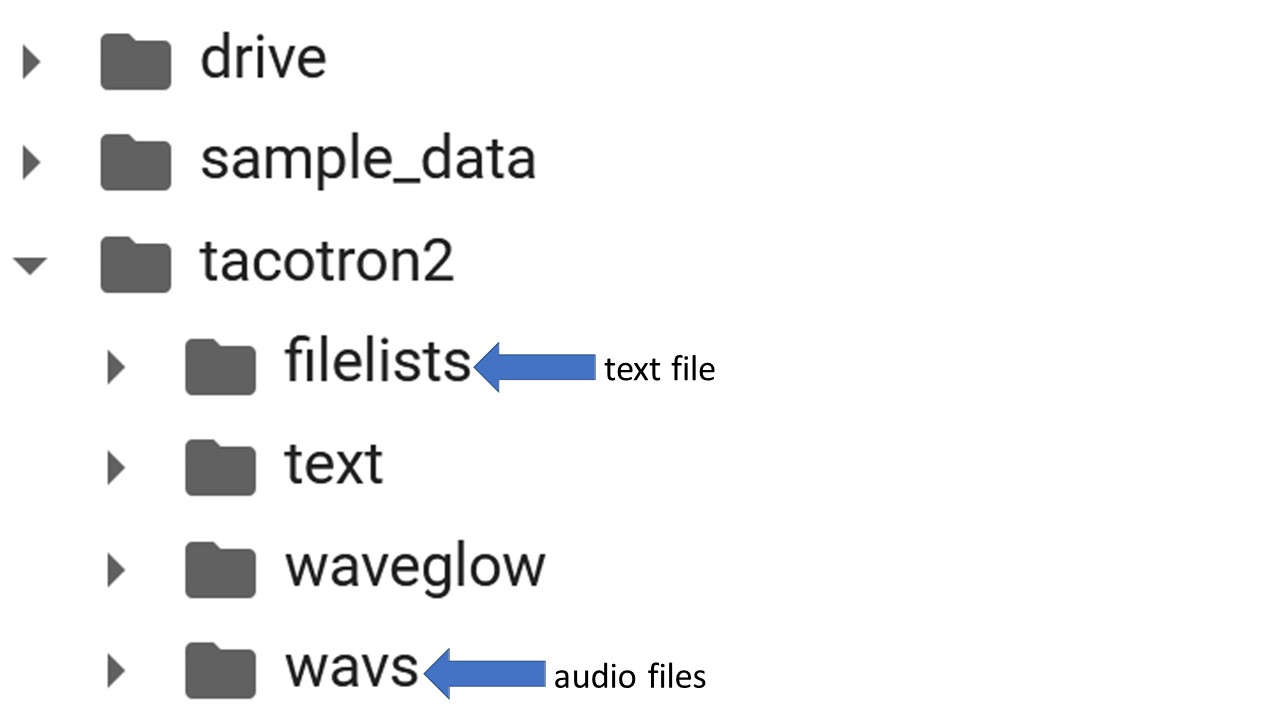

In [ ]:
cp /content/drive/MyDrive/wavs/* /content/tacotron2/wavs

### 上传数据方式2 - 压缩包上传（推荐）
上传压缩包到你的云盘

支持的压缩包格式：

APM, ARJ, CAB, CHM, CPIO, CramFS, DEB, DMG, FAT,

HFS, ISO, LZH, LZMA, LZMA2, MBR, MSI, MSLZ, NSIS, NTFS, RAR,

7z, ZIP, GZIP, BZIP2, XZ, TAR

确保压缩包下至少有两个文件夹

一个`wavs`文件夹，下面放音频文件

一个`filelists`文件夹，下面放音频文件列表

In [ ]:
#@markdown 压缩包路径

dataset_path = "/content/drive/MyDrive/dataset/DAL.zip"  #@param {type:"string"}
!sudo apt-get install p7zip-full p7zip-rar
if os.getcwd() != '/content/tacotron2':
    os.chdir('/content/tacotron2')
os.system("7z x {path}".format(path=dataset_path))

# 准备模型

In [ ]:
#@title 训练模型的代码
%matplotlib inline

import time
import argparse
import math
from numpy import finfo

import torch
from distributed import apply_gradient_allreduce
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

from model import Tacotron2
from data_utils import TextMelLoader, TextMelCollate
from loss_function import Tacotron2Loss
from logger import Tacotron2Logger
from hparams import create_hparams
 
import random
import numpy as np

import layers
from utils import load_wav_to_torch, load_filepaths_and_text
from text import text_to_sequence
from math import e
#from tqdm import tqdm # Terminal
#from tqdm import tqdm_notebook as tqdm # Legacy Notebook TQDM
from tqdm.notebook import tqdm # Modern Notebook TQDM
from distutils.dir_util import copy_tree
import matplotlib.pylab as plt

def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

def create_mels():
    print("Generating Mels")
    stft = layers.TacotronSTFT(
                hparams.filter_length, hparams.hop_length, hparams.win_length,
                hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                hparams.mel_fmax)
    def save_mel(filename):
        audio, sampling_rate = load_wav_to_torch(filename)
        if sampling_rate != stft.sampling_rate:
            raise ValueError("{} {} SR doesn't match target {} SR".format(filename, 
                sampling_rate, stft.sampling_rate))
        audio_norm = audio / hparams.max_wav_value
        audio_norm = audio_norm.unsqueeze(0)
        audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
        melspec = stft.mel_spectrogram(audio_norm)
        melspec = torch.squeeze(melspec, 0).cpu().numpy()
        np.save(filename.replace('.wav', ''), melspec)

    import glob
    wavs = glob.glob('wavs/*.wav')
    for i in tqdm(wavs):
        save_mel(i)


def reduce_tensor(tensor, n_gpus):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    rt /= n_gpus
    return rt


def init_distributed(hparams, n_gpus, rank, group_name):
    assert torch.cuda.is_available(), "Distributed mode requires CUDA."
    print("Initializing Distributed")

    # Set cuda device so everything is done on the right GPU.
    torch.cuda.set_device(rank % torch.cuda.device_count())

    # Initialize distributed communication
    dist.init_process_group(
        backend=hparams.dist_backend, init_method=hparams.dist_url,
        world_size=n_gpus, rank=rank, group_name=group_name)

    print("Done initializing distributed")


def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = TextMelLoader(hparams.validation_files, hparams)
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    if hparams.distributed_run:
        train_sampler = DistributedSampler(trainset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True

    train_loader = DataLoader(trainset, num_workers=1, shuffle=shuffle,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn


def prepare_directories_and_logger(output_directory, log_directory, rank):
    if rank == 0:
        if not os.path.isdir(output_directory):
            os.makedirs(output_directory)
            os.chmod(output_directory, 0o775)
        logger = Tacotron2Logger(os.path.join(output_directory, log_directory))
    else:
        logger = None
    return logger


def load_model(hparams):
    model = Tacotron2(hparams).cuda()
    if hparams.fp16_run:
        model.decoder.attention_layer.score_mask_value = finfo('float16').min

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    return model


def warm_start_model(checkpoint_path, model, ignore_layers):
    assert os.path.isfile(checkpoint_path)
    print("Warm starting model from checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = checkpoint_dict['state_dict']
    if len(ignore_layers) > 0:
        model_dict = {k: v for k, v in model_dict.items()
                      if k not in ignore_layers}
        dummy_dict = model.state_dict()
        dummy_dict.update(model_dict)
        model_dict = dummy_dict
    model.load_state_dict(model_dict)
    return model


def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration


def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    print("Saving model and optimizer state at iteration {} to {}".format(
        iteration, filepath))
    try:
        torch.save({'iteration': iteration,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate}, filepath)
    except KeyboardInterrupt:
        print("interrupt received while saving, waiting for save to complete.")
        torch.save({'iteration': iteration,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),'learning_rate': learning_rate}, filepath)
    print("Model Saved")

def plot_alignment(alignment, info=None):
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(int(alignment_graph_width/100), int(alignment_graph_height/100)))
    im = ax.imshow(alignment, cmap='inferno', aspect='auto', origin='lower',
                   interpolation='none')
    ax.autoscale(enable=True, axis="y", tight=True)
    fig.colorbar(im, ax=ax)
    xlabel = 'Decoder timestep'
    if info is not None:
        xlabel += '\n\n' + info
    plt.xlabel(xlabel)
    plt.ylabel('Encoder timestep')
    plt.tight_layout()
    fig.canvas.draw()
    plt.show()

def validate(model, criterion, valset, iteration, batch_size, n_gpus,
             collate_fn, logger, distributed_run, rank, epoch, start_eposh, learning_rate):
    """Handles all the validation scoring and printing"""
    model.eval()
    with torch.no_grad():
        val_sampler = DistributedSampler(valset) if distributed_run else None
        val_loader = DataLoader(valset, sampler=val_sampler, num_workers=1,
                                shuffle=False, batch_size=batch_size,
                                pin_memory=False, collate_fn=collate_fn)

        val_loss = 0.0
        for i, batch in enumerate(val_loader):
            x, y = model.parse_batch(batch)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            if distributed_run:
                reduced_val_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_val_loss = loss.item()
            val_loss += reduced_val_loss
        val_loss = val_loss / (i + 1)

    model.train()
    if rank == 0:
        print("Epoch: {} Validation loss {}: {:9f}  Time: {:.1f}m LR: {:.6f}".format(epoch, iteration, val_loss,(time.perf_counter()-start_eposh)/60, learning_rate))
        logger.log_validation(val_loss, model, y, y_pred, iteration)
        if hparams.show_alignments:
            %matplotlib inline
            _, mel_outputs, gate_outputs, alignments = y_pred
            idx = random.randint(0, alignments.size(0) - 1)
            plot_alignment(alignments[idx].data.cpu().numpy().T)

def train(output_directory, log_directory, checkpoint_path, warm_start, n_gpus,
          rank, group_name, hparams, log_directory2):
    """Training and validation logging results to tensorboard and stdout

    Params
    ------
    output_directory (string): directory to save checkpoints
    log_directory (string) directory to save tensorboard logs
    checkpoint_path(string): checkpoint path
    n_gpus (int): number of gpus
    rank (int): rank of current gpu
    hparams (object): comma separated list of "name=value" pairs.
    """
    if hparams.distributed_run:
        init_distributed(hparams, n_gpus, rank, group_name)

    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed(hparams.seed)

    model = load_model(hparams)
    learning_rate = hparams.learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=hparams.weight_decay)

    if hparams.fp16_run:
        from apex import amp
        model, optimizer = amp.initialize(
            model, optimizer, opt_level='O2')

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    criterion = Tacotron2Loss()

    logger = prepare_directories_and_logger(
        output_directory, log_directory, rank)

    train_loader, valset, collate_fn = prepare_dataloaders(hparams)

    # Load checkpoint if one exists
    iteration = 0
    epoch_offset = 0
    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        if warm_start:
            model = warm_start_model(
                checkpoint_path, model, hparams.ignore_layers)
        else:
            model, optimizer, _learning_rate, iteration = load_checkpoint(
                checkpoint_path, model, optimizer)
            if hparams.use_saved_learning_rate:
                learning_rate = _learning_rate
            iteration += 1  # next iteration is iteration + 1
            epoch_offset = max(0, int(iteration / len(train_loader)))
    else:
      os.path.isfile("tacotron2_statedict.pt")
      model = warm_start_model("tacotron2_statedict.pt", model, hparams.ignore_layers)
      # download LJSpeech pretrained model if no checkpoint already exists
    
    start_eposh = time.perf_counter()
    learning_rate = 0.0
    model.train()
    is_overflow = False
    # ================ MAIN TRAINNIG LOOP! ===================
    for epoch in tqdm(range(epoch_offset, hparams.epochs)):
        print("\nStarting Epoch: {} Iteration: {}".format(epoch, iteration))
        start_eposh = time.perf_counter() # eposh is russian, not a typo
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            start = time.perf_counter()
            if iteration < hparams.decay_start: learning_rate = hparams.A_
            else: iteration_adjusted = iteration - hparams.decay_start; learning_rate = (hparams.A_*(e**(-iteration_adjusted/hparams.B_))) + hparams.C_
            learning_rate = max(hparams.min_learning_rate, learning_rate) # output the largest number
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate

            model.zero_grad()
            x, y = model.parse_batch(batch)
            y_pred = model(x)

            loss = criterion(y_pred, y)
            if hparams.distributed_run:
                reduced_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_loss = loss.item()
            if hparams.fp16_run:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if hparams.fp16_run:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    amp.master_params(optimizer), hparams.grad_clip_thresh)
                is_overflow = math.isnan(grad_norm)
            else:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), hparams.grad_clip_thresh)

            optimizer.step()

            if not is_overflow and rank == 0:
                duration = time.perf_counter() - start
                logger.log_training(
                    reduced_loss, grad_norm, learning_rate, duration, iteration)
                #print("Batch {} loss {:.6f} Grad Norm {:.6f} Time {:.6f}".format(iteration, reduced_loss, grad_norm, duration), end='\r', flush=True)

            iteration += 1
        validate(model, criterion, valset, iteration,
                 hparams.batch_size, n_gpus, collate_fn, logger,
                 hparams.distributed_run, rank, epoch, start_eposh, learning_rate)
        save_checkpoint(model, optimizer, learning_rate, iteration, checkpoint_path)
        if log_directory2 != None:
            copy_tree(log_directory, log_directory2)
def check_dataset(hparams):
    from utils import load_wav_to_torch, load_filepaths_and_text
    import os
    import numpy as np
    def check_arr(filelist_arr):
        for i, file in enumerate(filelist_arr):
            if len(file) > 2:
                print("|".join(file), "\nhas multiple '|', this may not be an error.")
            if hparams.load_mel_from_disk and '.wav' in file[0]:
                print("[WARNING]", file[0], " in filelist while expecting .npy .")
            else:
                if not hparams.load_mel_from_disk and '.npy' in file[0]:
                    print("[WARNING]", file[0], " in filelist while expecting .wav .")
            if (not os.path.exists(file[0])):
                print("|".join(file), "\n[WARNING] does not exist.")
            if len(file[1]) < 3:
                print("|".join(file), "\n[info] has no/very little text.")
            if not ((file[1].strip())[-1] in r"!?,.;:"):
                print("|".join(file), "\n[info] has no ending punctuation.")
            mel_length = 1
            if hparams.load_mel_from_disk and '.npy' in file[0]:
                melspec = torch.from_numpy(np.load(file[0], allow_pickle=True))
                mel_length = melspec.shape[1]
            if mel_length == 0:
                print("|".join(file), "\n[WARNING] has 0 duration.")
    print("Checking Training Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.training_files) # get split lines from training_files text file.
    check_arr(audiopaths_and_text)
    print("Checking Validation Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.validation_files) # get split lines from validation_files text file.
    check_arr(audiopaths_and_text)
    print("Finished Checking")

warm_start=False #sorry about that
n_gpus=1
rank=0
group_name=None

# ---- 这是定义的默认参数，可以不用管 ----
hparams = create_hparams()
model_filename = 'current_model'
hparams.training_files = "filelists/clipper_train_filelist.txt"
hparams.validation_files = "filelists/clipper_val_filelist.txt"
#hparams.use_mmi=True,          # not used in this notebook
#hparams.use_gaf=True,          # not used in this notebook
#hparams.max_gaf=0.5,           # not used in this notebook
#hparams.drop_frame_rate = 0.2  # not used in this notebook
hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1
hparams.decay_start = 15000
hparams.A_ = 5e-4
hparams.B_ = 8000
hparams.C_ = 0
hparams.min_learning_rate = 1e-5
generate_mels = True
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000
hparams.batch_size = 32
hparams.load_mel_from_disk = True
hparams.ignore_layers = []
hparams.epochs = 10000

torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark
output_directory = '/content/drive/MyDrive/colab/outdir' # Location to save Checkpoints
log_directory = '/content/tacotron2/logs' # Location to save Log files locally
log_directory2 = '/content/drive/MyDrive/colab/logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)e
checkpoint_path = output_directory+(r'/')+model_filename


In [ ]:
#@title 给你的模型取名（写字母数字）
model_filename = "kurumi" #@param {type:"string"}

In [ ]:
#@title 设置参数

#@markdown **这两个参数是最重要的。**

#@markdown 这个参数控制模型训练得多快。**不要设置太大，否则显卡会炸。**如果数据集比较大，设置在30左右比较好。

#@markdown 如果数据集里音频文件的数量和这个参数差不多，训练会失败。

hparams.batch_size = 22 #@param {type:"integer"}

#@markdown 这个参数控制训练的次数
hparams.epochs = 600 #@param {type:"integer"}

#The rest aren't that important
hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1
hparams.decay_start = 15000         # wait till decay_start to start decaying learning rate
hparams.A_ = 5e-4                   # Start/Max Learning Rate
hparams.B_ = 8000                   # Decay Rate
hparams.C_ = 0                      # Shift learning rate equation by this value
hparams.min_learning_rate = 1e-5    # Min Learning Rate
generate_mels = True # Don't change
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000
hparams.load_mel_from_disk = True
hparams.ignore_layers = [] # Layers to reset (None by default, other than foreign languages this param can be ignored)

torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark
output_directory = '/content/drive/MyDrive/colab/outdir' # Location to save Checkpoints
log_directory = '/content/tacotron2/logs' # Location to save Log files locally
log_directory2 = '/content/drive/MyDrive/colab/logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename

In [ ]:
#@title 数据集文件列表
#@markdown 如果要求不高，两个列表用同一个文件即可

#@markdown 训练集文件列表
training_files_name = "list.txt" #@param {type:"string"}
#@markdown 验证集文件列表
validation_files_name = "list.txt" #@param {type:"string"}
#@markdown 预处理文本的cleaner

hparams_prefix = "/content/tacotron2/filelists/"
text_cleaner='japanese_phrase_cleaners' #@param {type:"string"}
text_cleaners=[text_cleaner]

training_files = hparams_prefix + training_files_name
validation_files = hparams_prefix + validation_files_name

hparams.training_files = training_files
hparams.validation_files = validation_files
hparams.text_cleaners = text_cleaners

### 各种cleaner的效果示例
### 1. 'japanese_cleaners'
#### 处理前
何かあったらいつでも話して下さい。学院のことじゃなく、私事に関することでも何でも
#### 处理后
nanikaacltaraitsudemohanashItekudasai.gakuiNnokotojanaku,shijinikaNsurukotodemonanidemo.
### 2. 'japanese_tokenization_cleaners'
#### 处理前
何かあったらいつでも話して下さい。学院のことじゃなく、私事に関することでも何でも
#### 处理后
nani ka acl tara itsu demo hanashi te kudasai. gakuiN no koto ja naku, shiji nikaNsuru koto de mo naNdemo.
### 3. 'japanese_accent_cleaners'
#### 处理前
何かあったらいつでも話して下さい。学院のことじゃなく、私事に関することでも何でも
#### 处理后
:na)nika a)cltara i)tsudemo ha(na)shIte ku(dasa)i.:ga(kuiNno ko(to)janaku,:shi)jini ka(Nsu)ru ko(to)demo na)nidemo.
### 4. 'japanese_phrase_cleaners'
#### 处理前
何かあったらいつでも話して下さい。学院のことじゃなく、私事に関することでも何でも
#### 处理后
nanika acltara itsudemo hanashIte kudasai. gakuiNno kotojanaku, shijini kaNsuru kotodemo nanidemo.
### 5. 'english_cleaners'
#### 处理前
nanika acltara itsudemo hanashIte kudasai. gakuiNno kotojanaku, shijini kaNsuru kotodemo nanidemo.
#### 处理后
nanika acltara itsudemo hanashIte kudasai. gakuiNno kotojanaku, shijini kaNsuru kotodemo nanidemo.

In [ ]:
#@title 生成MEL谱
# ---- Replace .wav with .npy in filelists ----
!sed -i -- 's,.wav|,.npy|,g' filelists/*.txt
# ---- Replace .wav with .npy in filelists ----
if generate_mels:
    create_mels()

Generating Mels


  0%|          | 0/1385 [00:00<?, ?it/s]

In [ ]:
#@title 检查数据集
#@markdown 没有error和warning就算成功
if os.getcwd() != '/content/tacotron2':
    os.chdir('/content/tacotron2')
check_dataset(hparams)

#训练

FP16 Run: False
Dynamic Loss Scaling: True
Distributed Run: False
cuDNN Enabled: True
cuDNN Benchmark: False
Loading checkpoint '/content/drive/MyDrive/colab/outdir/kurumi'
Loaded checkpoint '/content/drive/MyDrive/colab/outdir/kurumi' from iteration 18472


  0%|          | 0/303 [00:00<?, ?it/s]


Starting Epoch: 297 Iteration: 18473


  0%|          | 0/62 [00:00<?, ?it/s]

Downloading: "https://github.com/r9y9/open_jtalk/releases/download/v1.11.1/open_jtalk_dic_utf_8-1.11.tar.gz"


dic.tar.gz: 0.00B [00:00, ?B/s]

Extracting tar file /usr/local/lib/python3.7/dist-packages/pyopenjtalk/dic.tar.gz
Epoch: 297 Validation loss 18535:  0.143754  Time: 4.2m LR: 0.000321


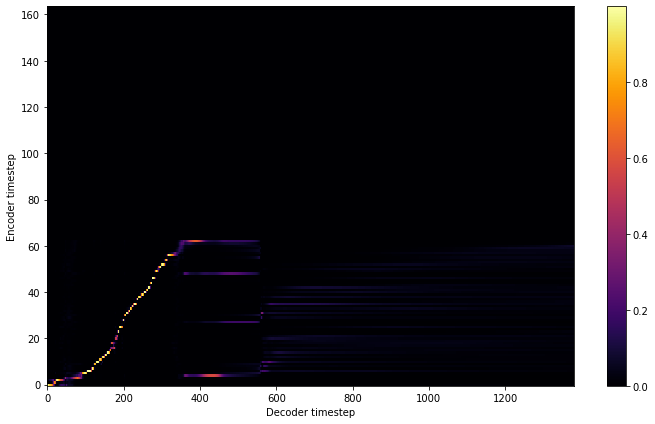

Saving model and optimizer state at iteration 18535 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 298 Iteration: 18535


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 298 Validation loss 18597:  0.138380  Time: 4.1m LR: 0.000319


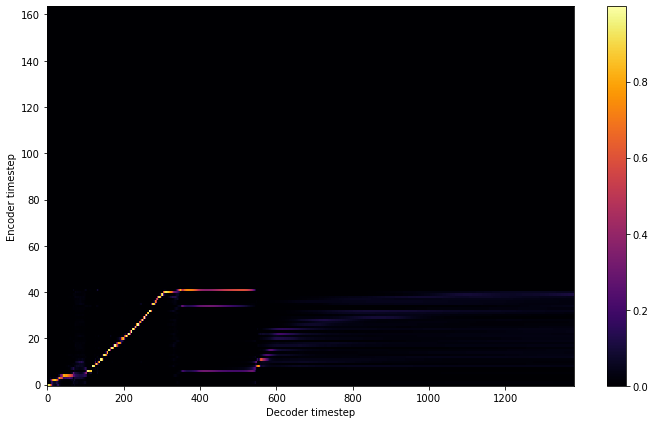

Saving model and optimizer state at iteration 18597 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 299 Iteration: 18597


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 299 Validation loss 18659:  0.131510  Time: 4.1m LR: 0.000317


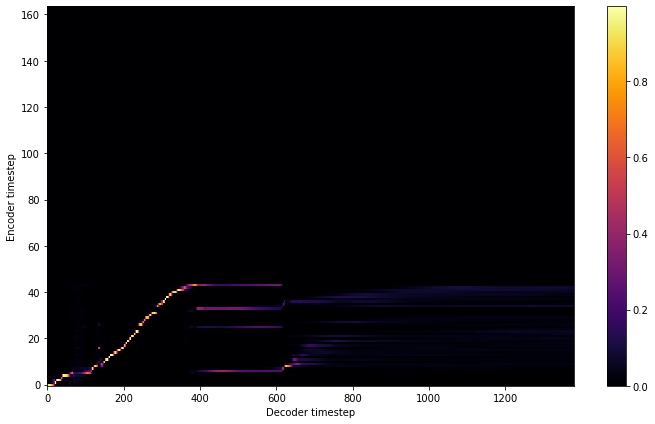

Saving model and optimizer state at iteration 18659 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 300 Iteration: 18659


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 300 Validation loss 18721:  0.129031  Time: 4.1m LR: 0.000314


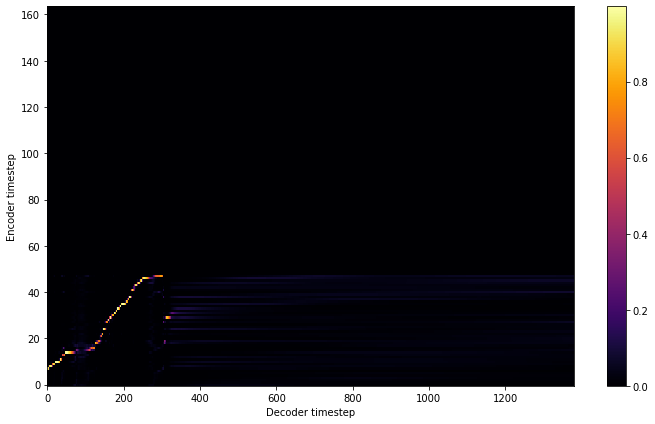

Saving model and optimizer state at iteration 18721 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 301 Iteration: 18721


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 301 Validation loss 18783:  0.127567  Time: 4.1m LR: 0.000312


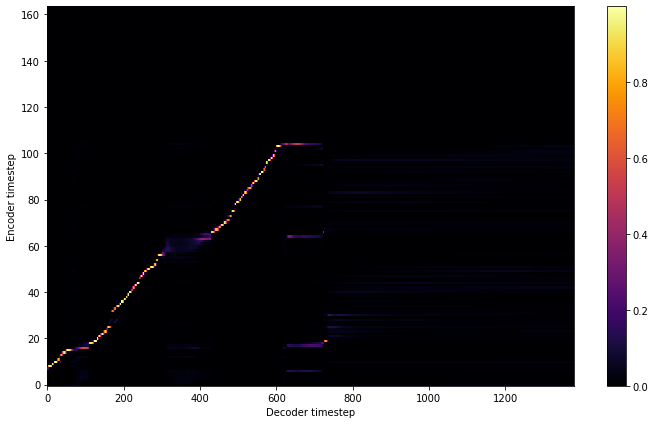

Saving model and optimizer state at iteration 18783 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 302 Iteration: 18783


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 302 Validation loss 18845:  0.127716  Time: 4.1m LR: 0.000309


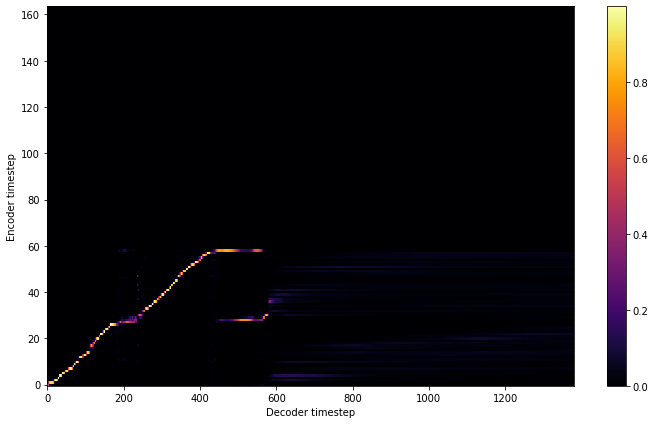

Saving model and optimizer state at iteration 18845 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 303 Iteration: 18845


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 303 Validation loss 18907:  0.127004  Time: 4.1m LR: 0.000307


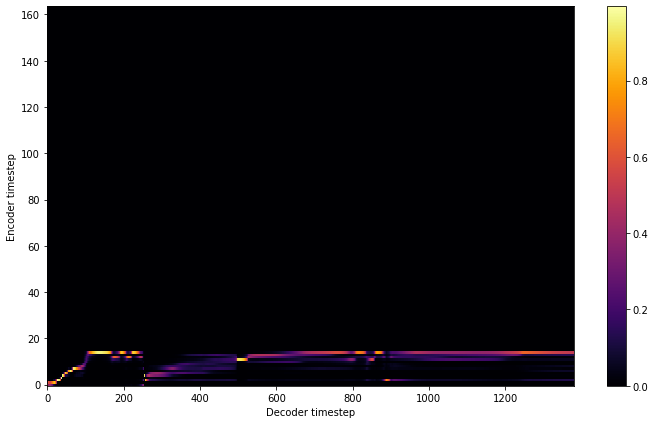

Saving model and optimizer state at iteration 18907 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 304 Iteration: 18907


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 304 Validation loss 18969:  0.125728  Time: 4.1m LR: 0.000304


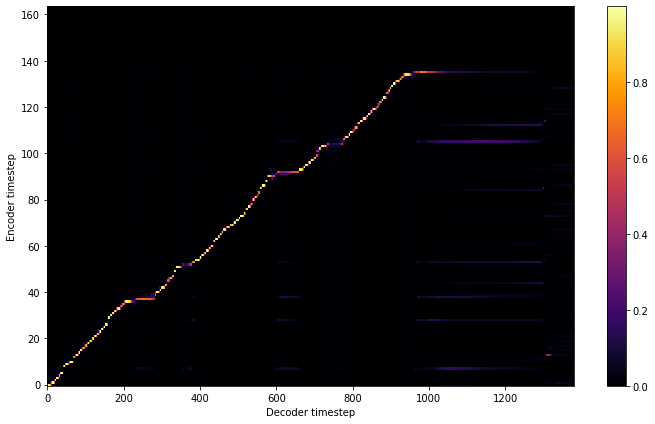

Saving model and optimizer state at iteration 18969 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 305 Iteration: 18969


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 305 Validation loss 19031:  0.125194  Time: 4.1m LR: 0.000302


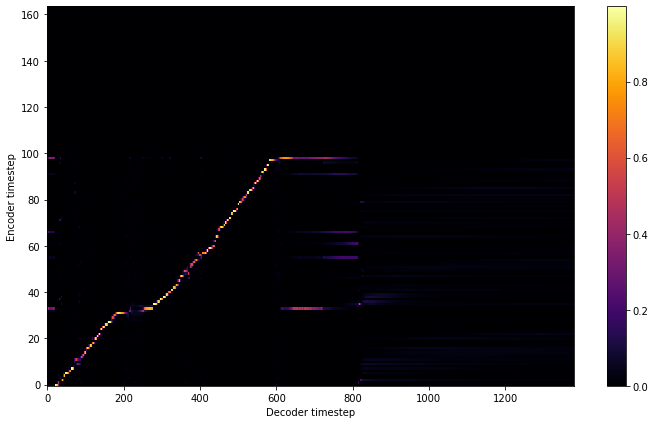

Saving model and optimizer state at iteration 19031 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 306 Iteration: 19031


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 306 Validation loss 19093:  0.124468  Time: 4.0m LR: 0.000300


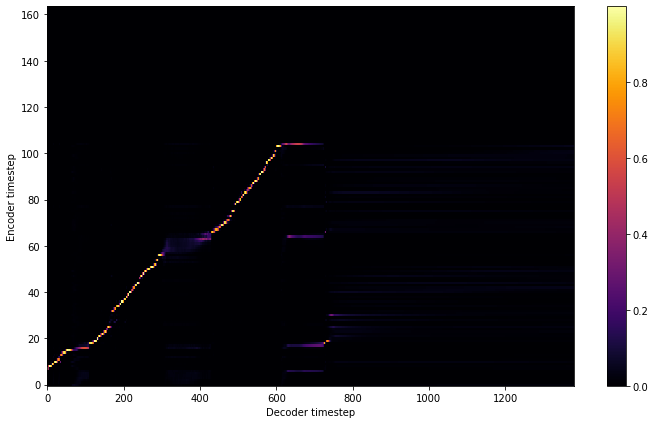

Saving model and optimizer state at iteration 19093 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 307 Iteration: 19093


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 307 Validation loss 19155:  0.123791  Time: 4.1m LR: 0.000297


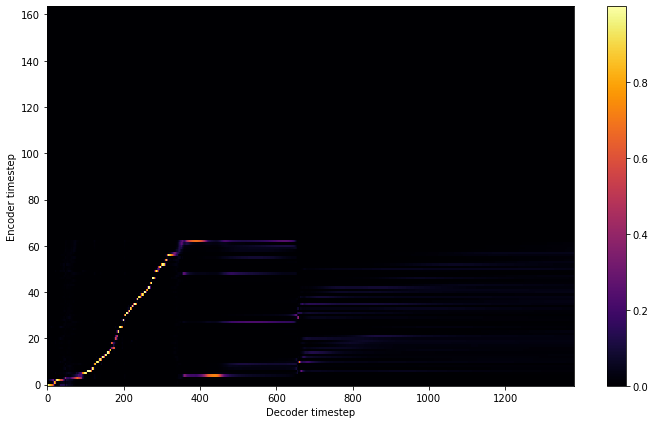

Saving model and optimizer state at iteration 19155 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 308 Iteration: 19155


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 308 Validation loss 19217:  0.123864  Time: 4.1m LR: 0.000295


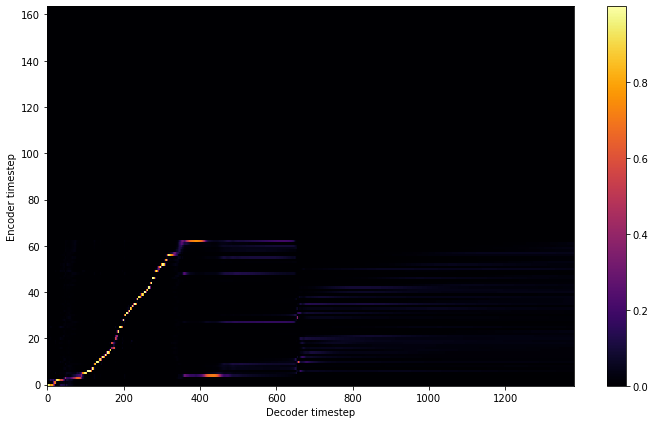

Saving model and optimizer state at iteration 19217 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 309 Iteration: 19217


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 309 Validation loss 19279:  0.121880  Time: 4.1m LR: 0.000293


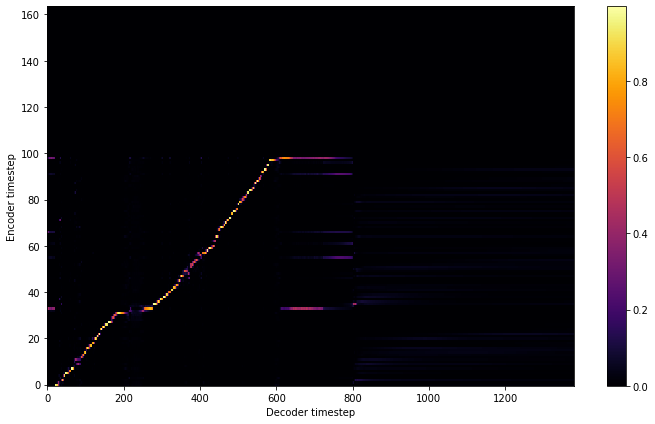

Saving model and optimizer state at iteration 19279 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 310 Iteration: 19279


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 310 Validation loss 19341:  0.122397  Time: 4.1m LR: 0.000291


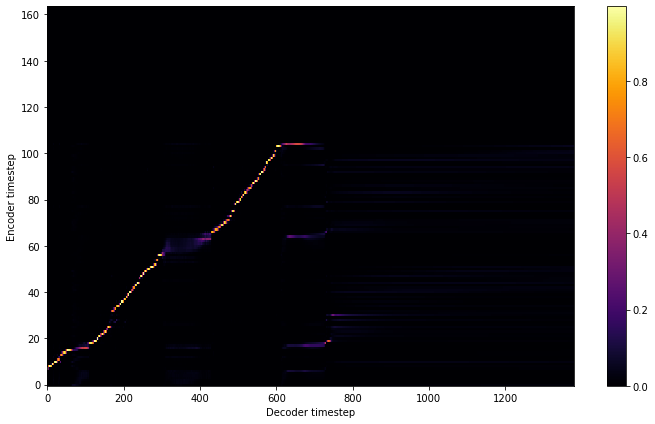

Saving model and optimizer state at iteration 19341 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 311 Iteration: 19341


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 311 Validation loss 19403:  0.122191  Time: 4.0m LR: 0.000288


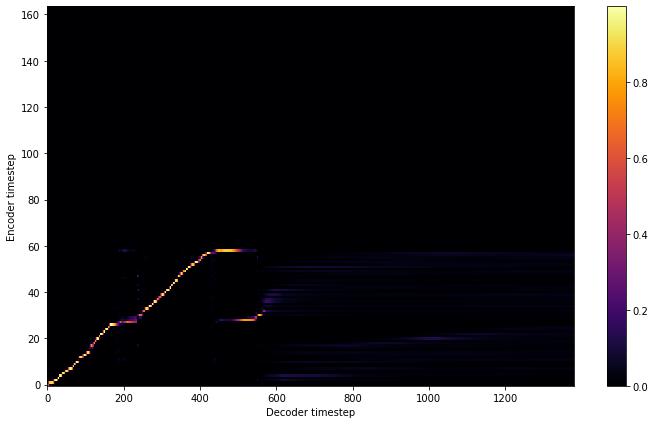

Saving model and optimizer state at iteration 19403 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 312 Iteration: 19403


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 312 Validation loss 19465:  0.122443  Time: 4.1m LR: 0.000286


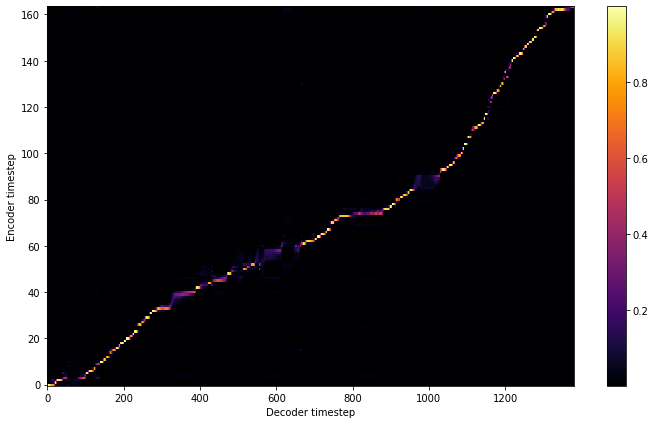

Saving model and optimizer state at iteration 19465 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 313 Iteration: 19465


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 313 Validation loss 19527:  0.122238  Time: 4.1m LR: 0.000284


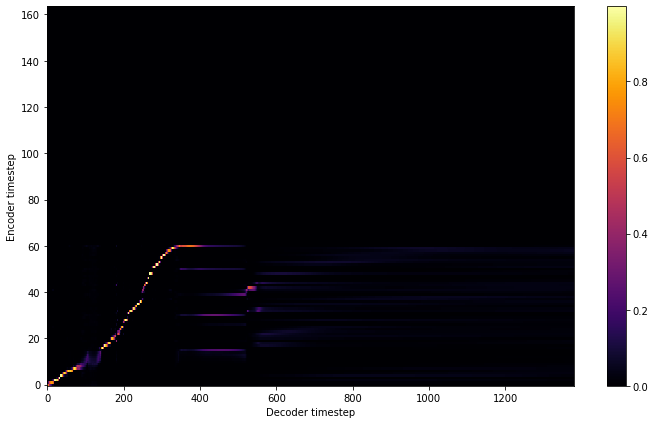

Saving model and optimizer state at iteration 19527 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 314 Iteration: 19527


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 314 Validation loss 19589:  0.122428  Time: 4.1m LR: 0.000282


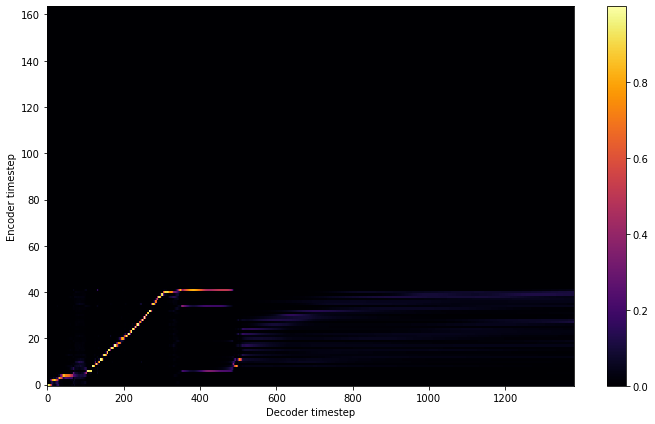

Saving model and optimizer state at iteration 19589 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 315 Iteration: 19589


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 315 Validation loss 19651:  0.123940  Time: 4.0m LR: 0.000280


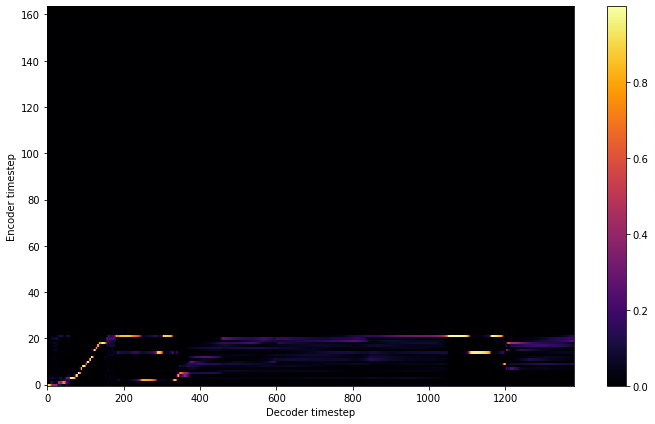

Saving model and optimizer state at iteration 19651 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 316 Iteration: 19651


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 316 Validation loss 19713:  0.122330  Time: 4.1m LR: 0.000277


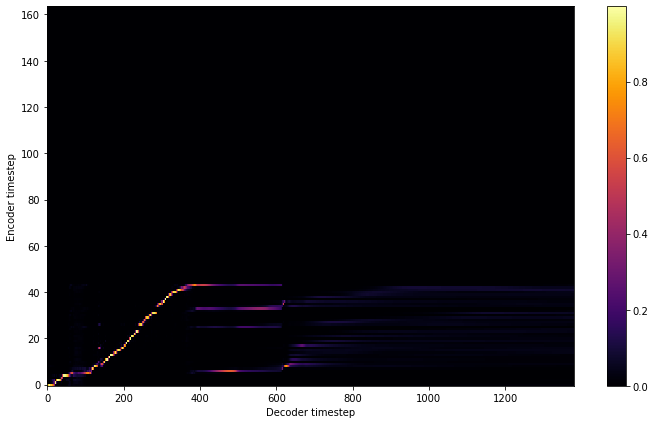

Saving model and optimizer state at iteration 19713 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 317 Iteration: 19713


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 317 Validation loss 19775:  0.121234  Time: 4.1m LR: 0.000275


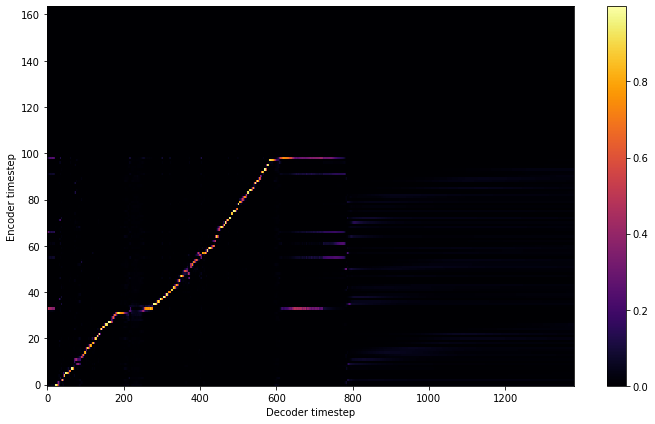

Saving model and optimizer state at iteration 19775 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 318 Iteration: 19775


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 318 Validation loss 19837:  0.120951  Time: 4.0m LR: 0.000273


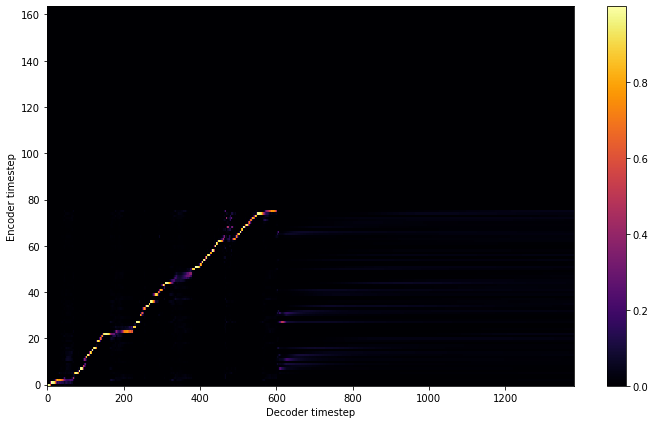

Saving model and optimizer state at iteration 19837 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 319 Iteration: 19837


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 319 Validation loss 19899:  0.120344  Time: 4.1m LR: 0.000271


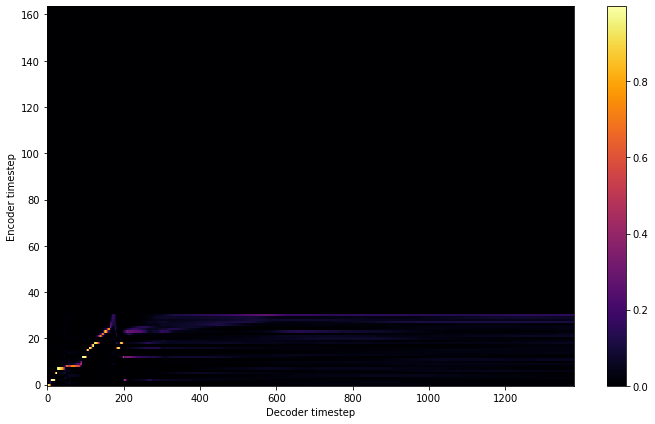

Saving model and optimizer state at iteration 19899 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 320 Iteration: 19899


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 320 Validation loss 19961:  0.120630  Time: 4.1m LR: 0.000269


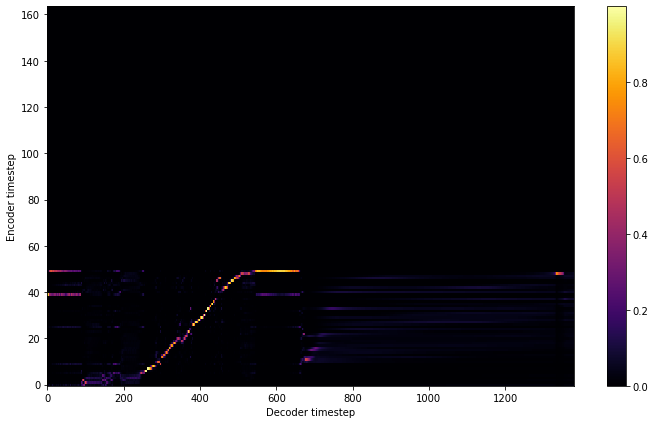

Saving model and optimizer state at iteration 19961 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 321 Iteration: 19961


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 321 Validation loss 20023:  0.120470  Time: 4.1m LR: 0.000267


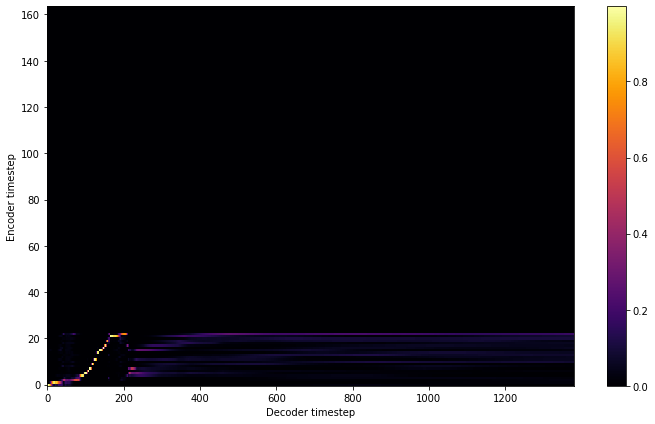

Saving model and optimizer state at iteration 20023 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 322 Iteration: 20023


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 322 Validation loss 20085:  0.118851  Time: 4.2m LR: 0.000265


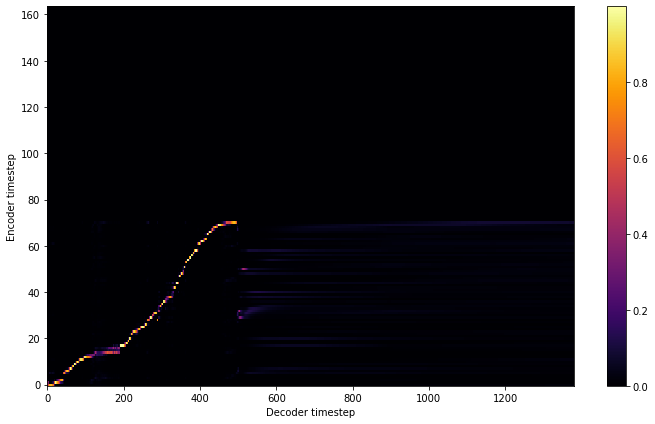

Saving model and optimizer state at iteration 20085 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 323 Iteration: 20085


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 323 Validation loss 20147:  0.118649  Time: 4.0m LR: 0.000263


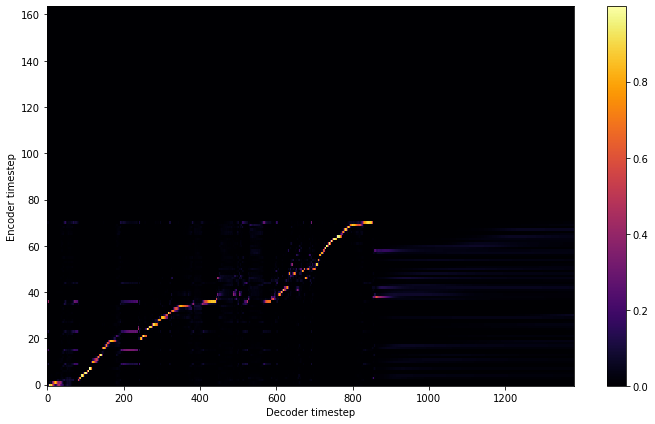

Saving model and optimizer state at iteration 20147 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 324 Iteration: 20147


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 324 Validation loss 20209:  0.119801  Time: 4.1m LR: 0.000261


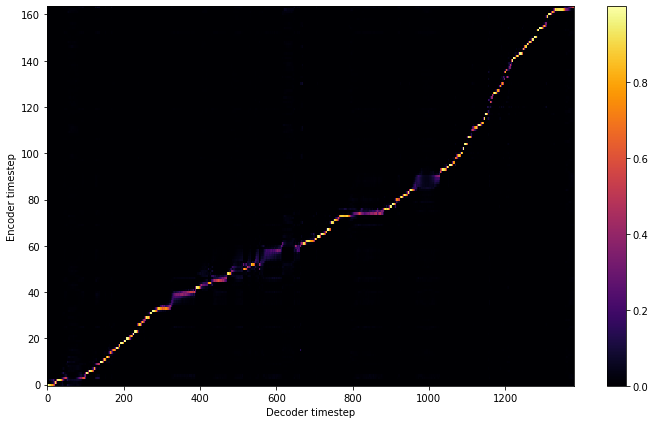

Saving model and optimizer state at iteration 20209 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 325 Iteration: 20209


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 325 Validation loss 20271:  0.118946  Time: 4.1m LR: 0.000259


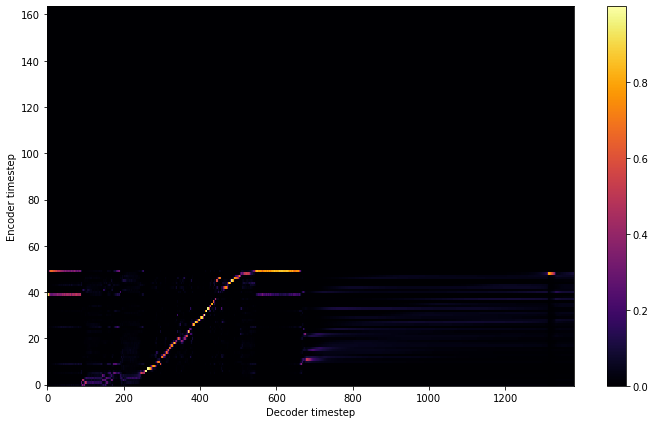

Saving model and optimizer state at iteration 20271 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 326 Iteration: 20271


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 326 Validation loss 20333:  0.118955  Time: 4.1m LR: 0.000257


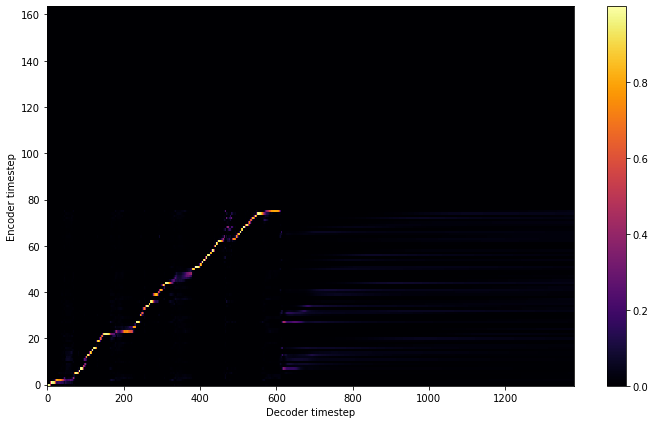

Saving model and optimizer state at iteration 20333 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 327 Iteration: 20333


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 327 Validation loss 20395:  0.117520  Time: 4.1m LR: 0.000255


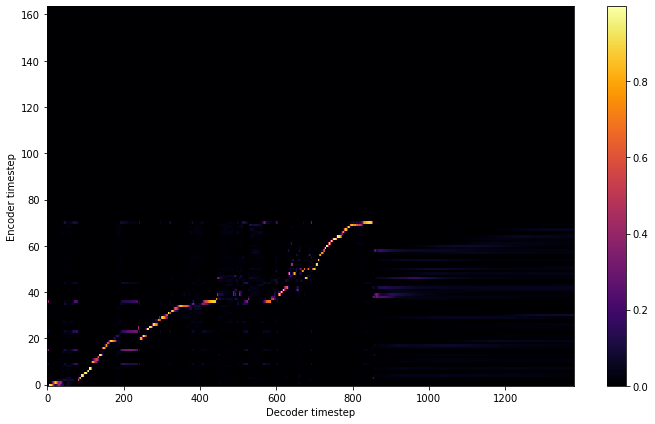

Saving model and optimizer state at iteration 20395 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 328 Iteration: 20395


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 328 Validation loss 20457:  0.118125  Time: 4.1m LR: 0.000253


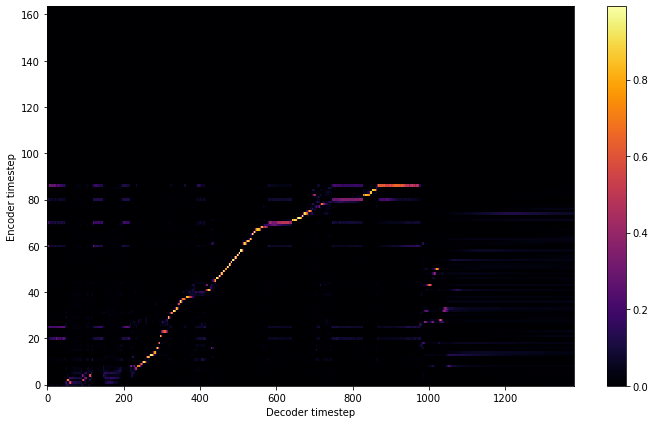

Saving model and optimizer state at iteration 20457 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 329 Iteration: 20457


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 329 Validation loss 20519:  0.117787  Time: 4.2m LR: 0.000251


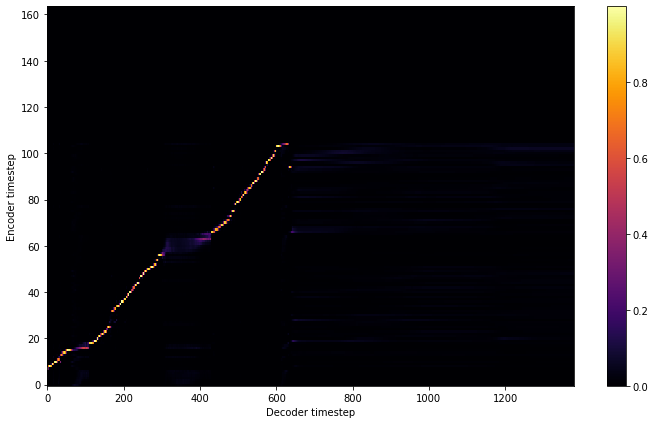

Saving model and optimizer state at iteration 20519 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 330 Iteration: 20519


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 330 Validation loss 20581:  0.117836  Time: 4.1m LR: 0.000249


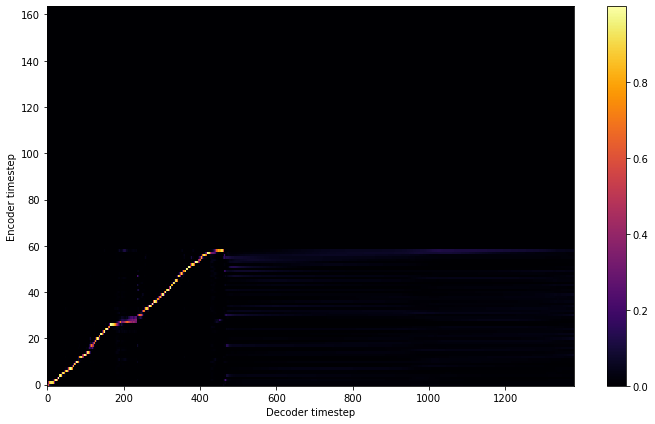

Saving model and optimizer state at iteration 20581 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 331 Iteration: 20581


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 331 Validation loss 20643:  0.118163  Time: 4.1m LR: 0.000247


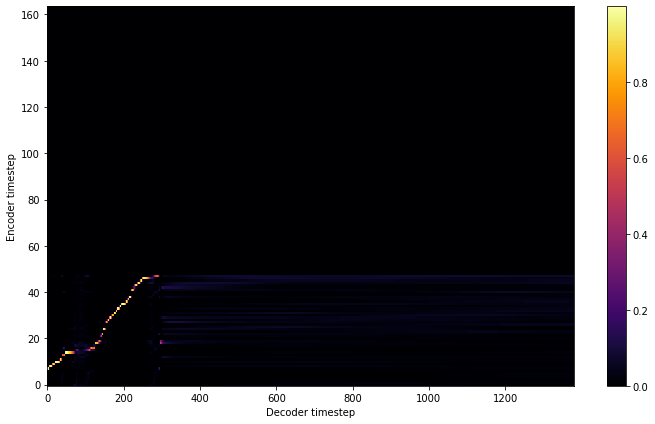

Saving model and optimizer state at iteration 20643 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 332 Iteration: 20643


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 332 Validation loss 20705:  0.116993  Time: 4.1m LR: 0.000245


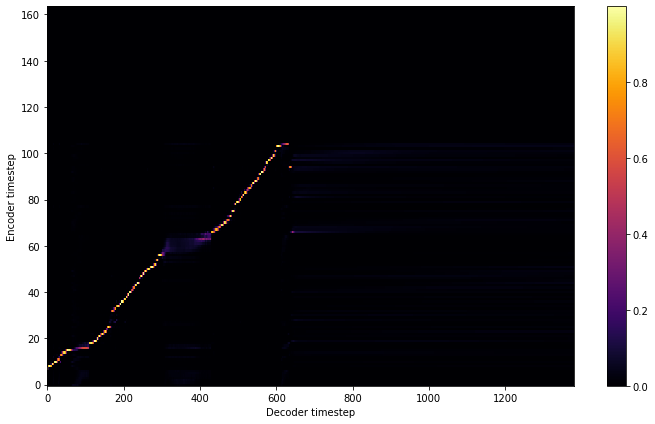

Saving model and optimizer state at iteration 20705 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 333 Iteration: 20705


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 333 Validation loss 20767:  0.117433  Time: 4.1m LR: 0.000243


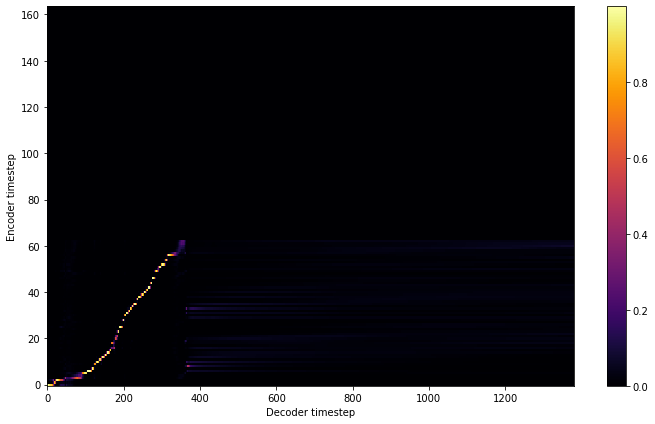

Saving model and optimizer state at iteration 20767 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 334 Iteration: 20767


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 334 Validation loss 20829:  0.121041  Time: 4.1m LR: 0.000241


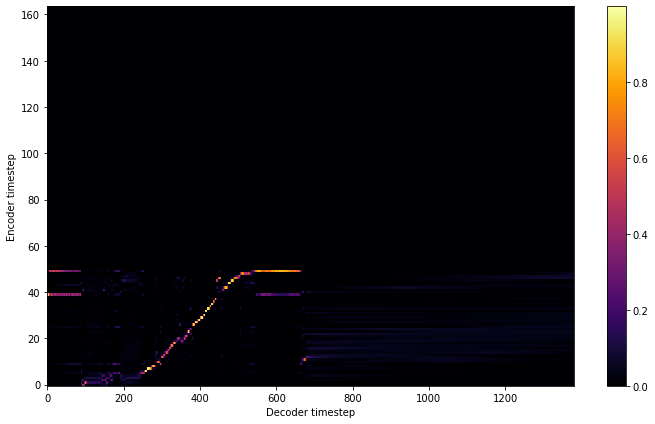

Saving model and optimizer state at iteration 20829 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 335 Iteration: 20829


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 335 Validation loss 20891:  0.117389  Time: 4.1m LR: 0.000239


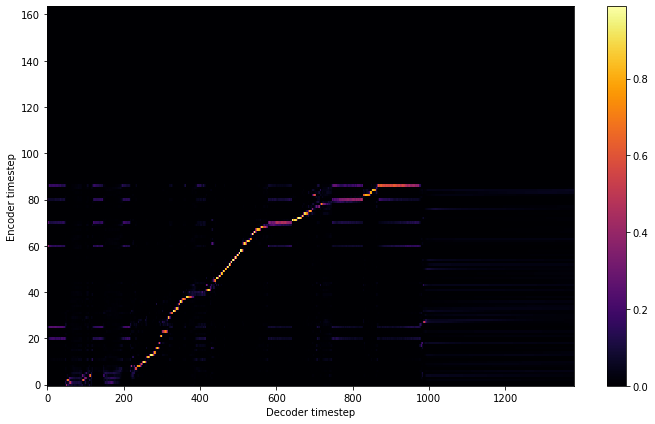

Saving model and optimizer state at iteration 20891 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 336 Iteration: 20891


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 336 Validation loss 20953:  0.117064  Time: 4.0m LR: 0.000238


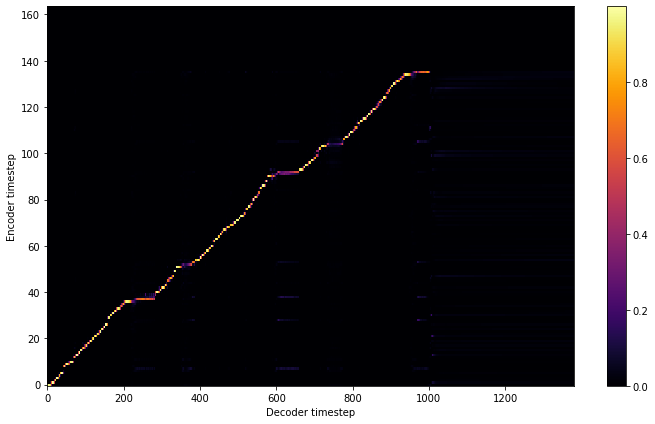

Saving model and optimizer state at iteration 20953 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 337 Iteration: 20953


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 337 Validation loss 21015:  0.120100  Time: 4.0m LR: 0.000236


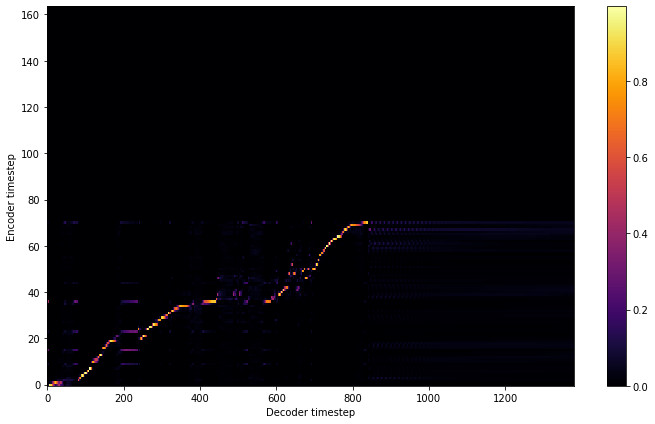

Saving model and optimizer state at iteration 21015 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 338 Iteration: 21015


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 338 Validation loss 21077:  0.118226  Time: 4.1m LR: 0.000234


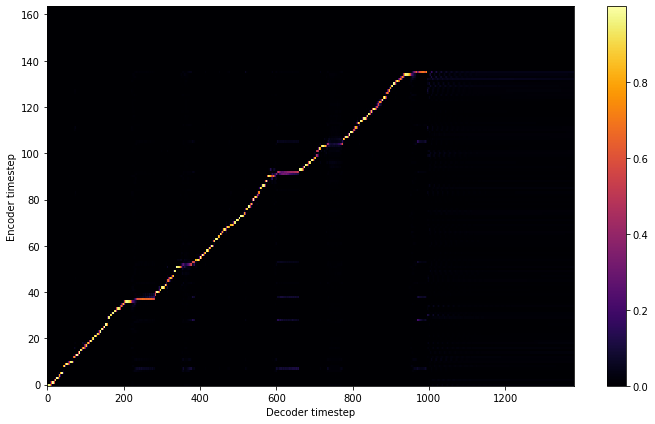

Saving model and optimizer state at iteration 21077 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 339 Iteration: 21077


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 339 Validation loss 21139:  0.118043  Time: 4.1m LR: 0.000232


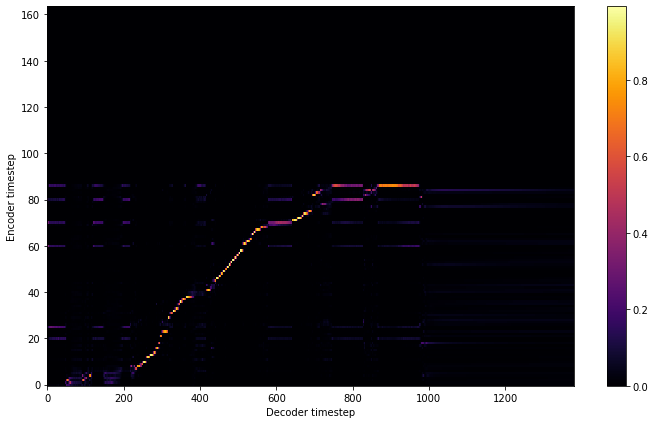

Saving model and optimizer state at iteration 21139 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 340 Iteration: 21139


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 340 Validation loss 21201:  0.118783  Time: 4.2m LR: 0.000230


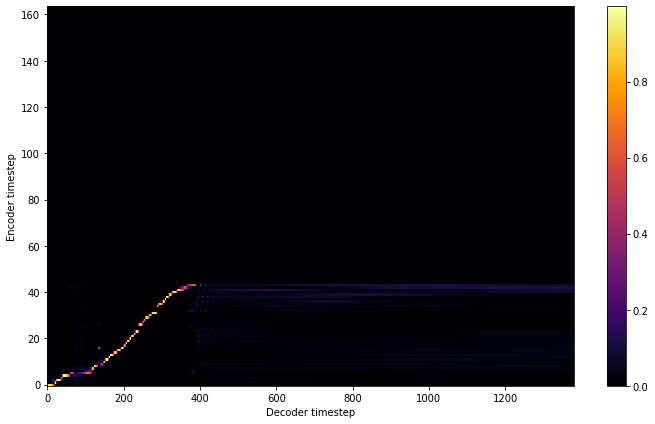

Saving model and optimizer state at iteration 21201 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 341 Iteration: 21201


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 341 Validation loss 21263:  0.118339  Time: 4.0m LR: 0.000229


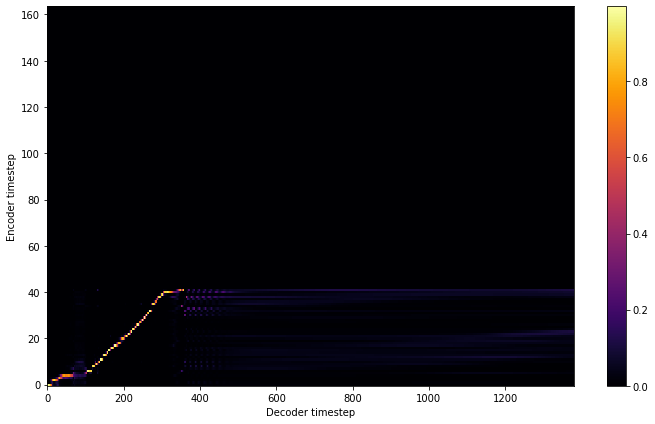

Saving model and optimizer state at iteration 21263 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 342 Iteration: 21263


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 342 Validation loss 21325:  0.116989  Time: 4.1m LR: 0.000227


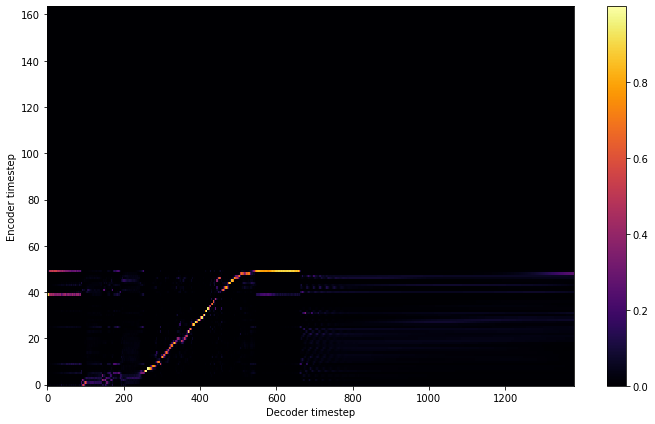

Saving model and optimizer state at iteration 21325 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 343 Iteration: 21325


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 343 Validation loss 21387:  0.114936  Time: 4.1m LR: 0.000225


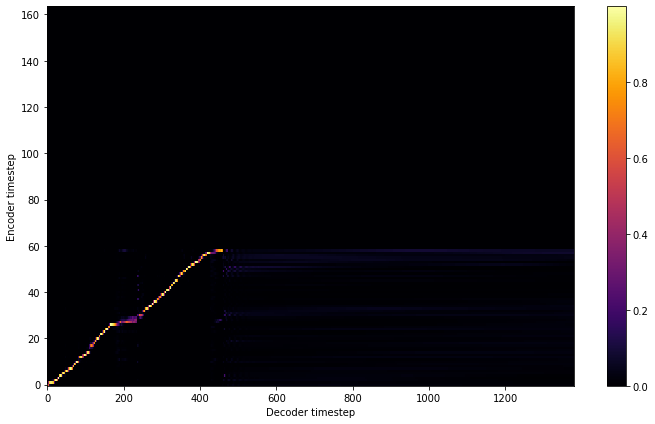

Saving model and optimizer state at iteration 21387 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 344 Iteration: 21387


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 344 Validation loss 21449:  0.115641  Time: 4.2m LR: 0.000223


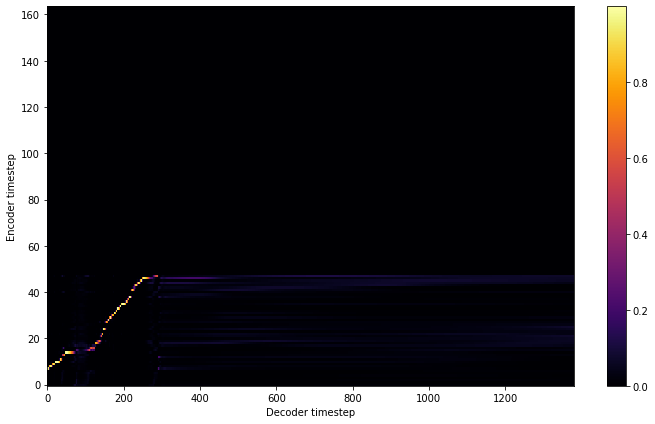

Saving model and optimizer state at iteration 21449 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 345 Iteration: 21449


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 345 Validation loss 21511:  0.114876  Time: 4.1m LR: 0.000222


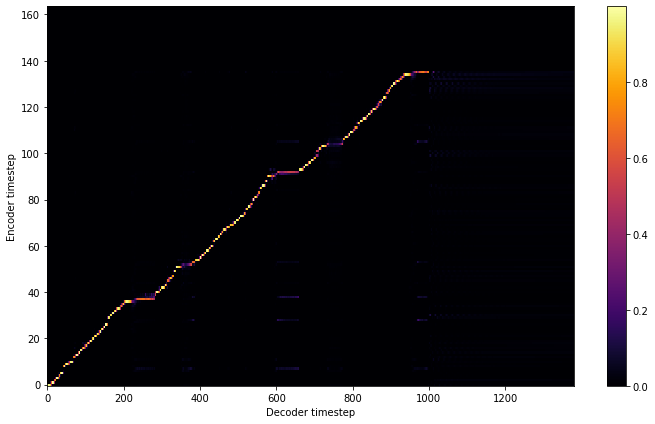

Saving model and optimizer state at iteration 21511 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 346 Iteration: 21511


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 346 Validation loss 21573:  0.114471  Time: 4.2m LR: 0.000220


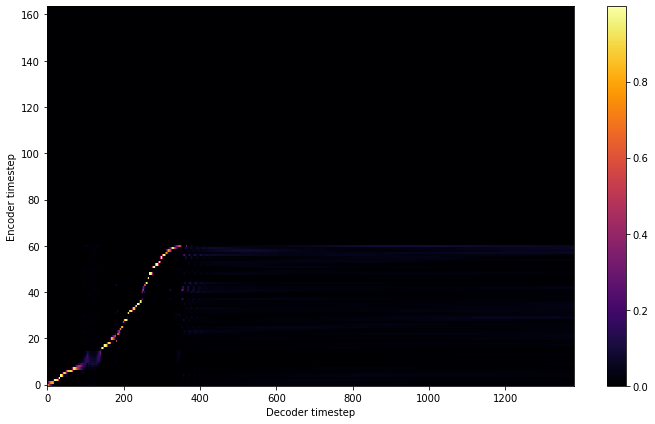

Saving model and optimizer state at iteration 21573 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 347 Iteration: 21573


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 347 Validation loss 21635:  0.117977  Time: 4.1m LR: 0.000218


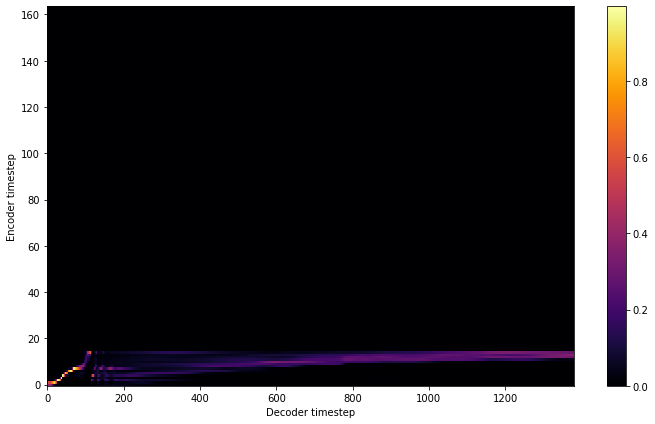

Saving model and optimizer state at iteration 21635 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 348 Iteration: 21635


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 348 Validation loss 21697:  0.115689  Time: 4.1m LR: 0.000217


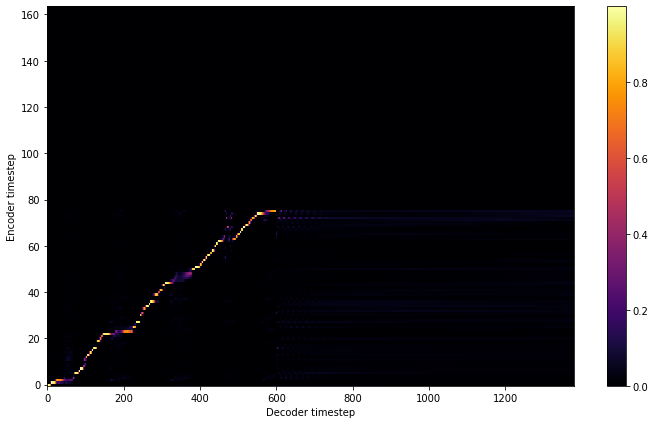

Saving model and optimizer state at iteration 21697 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 349 Iteration: 21697


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 349 Validation loss 21759:  0.115142  Time: 4.1m LR: 0.000215


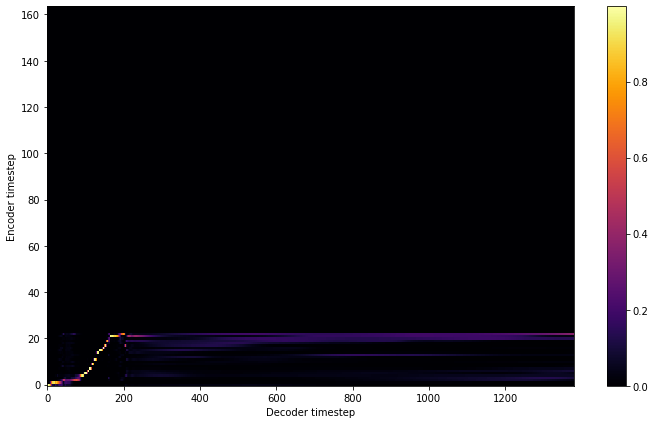

Saving model and optimizer state at iteration 21759 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 350 Iteration: 21759


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 350 Validation loss 21821:  0.114026  Time: 4.1m LR: 0.000213


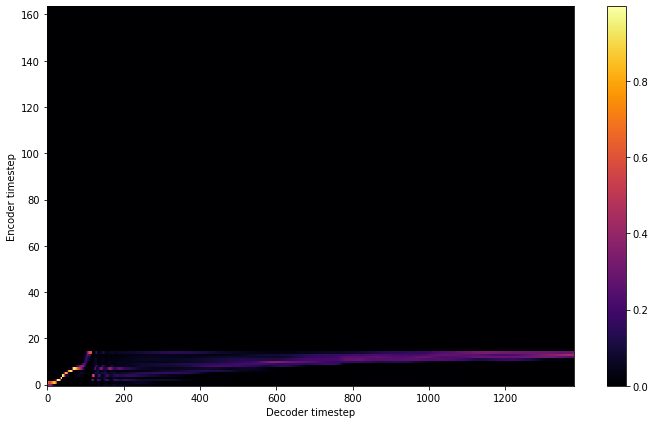

Saving model and optimizer state at iteration 21821 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 351 Iteration: 21821


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 351 Validation loss 21883:  0.114309  Time: 4.1m LR: 0.000212


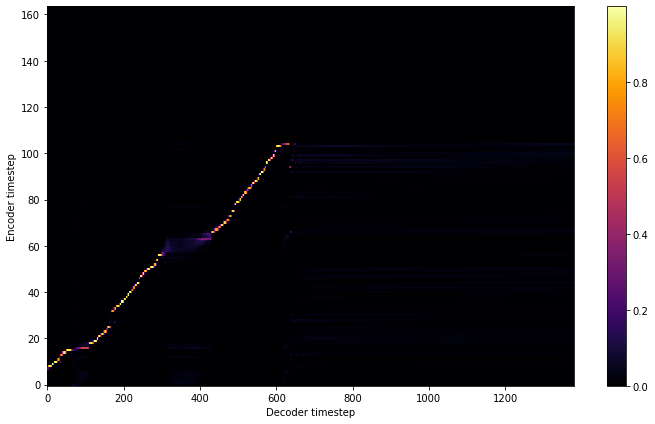

Saving model and optimizer state at iteration 21883 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 352 Iteration: 21883


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 352 Validation loss 21945:  0.113691  Time: 4.1m LR: 0.000210


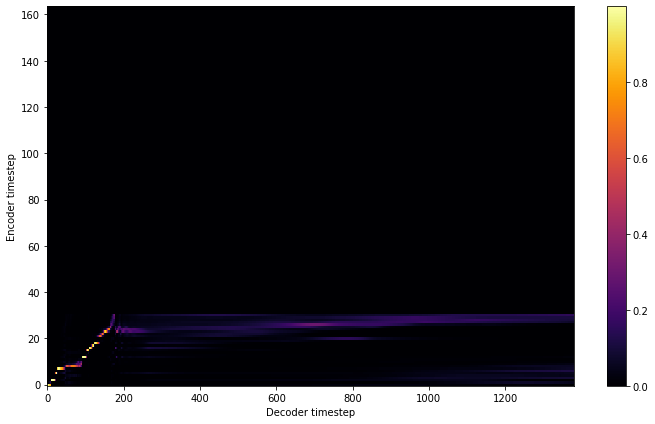

Saving model and optimizer state at iteration 21945 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 353 Iteration: 21945


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 353 Validation loss 22007:  0.115260  Time: 4.1m LR: 0.000208


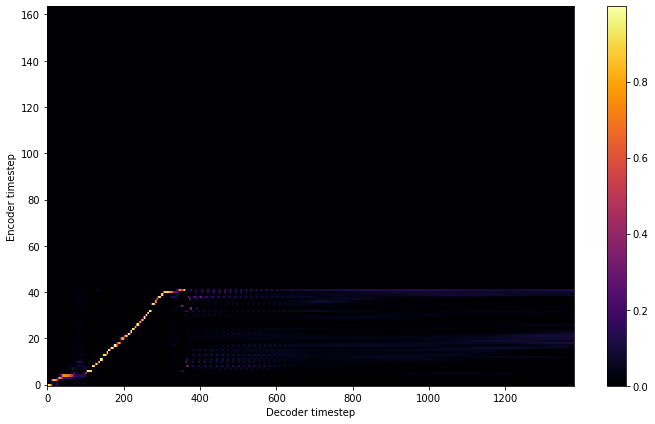

Saving model and optimizer state at iteration 22007 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 354 Iteration: 22007


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 354 Validation loss 22069:  0.115051  Time: 4.1m LR: 0.000207


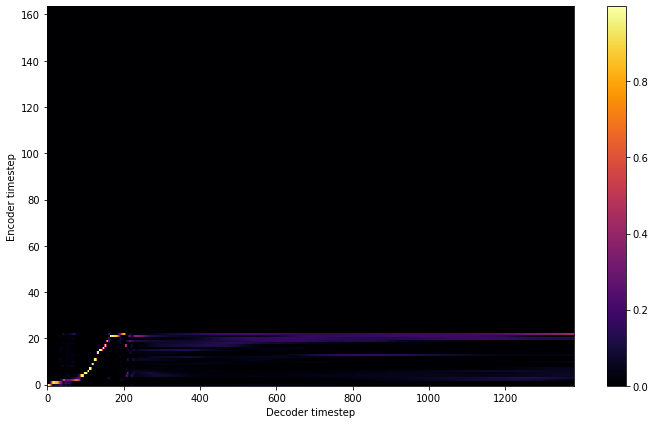

Saving model and optimizer state at iteration 22069 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 355 Iteration: 22069


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 355 Validation loss 22131:  0.113520  Time: 4.1m LR: 0.000205


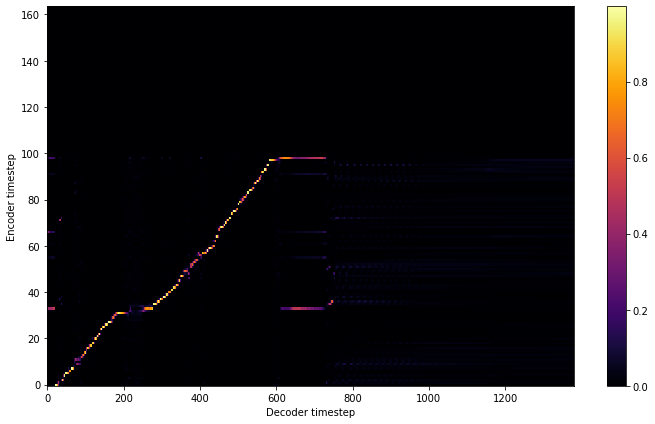

Saving model and optimizer state at iteration 22131 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 356 Iteration: 22131


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 356 Validation loss 22193:  0.113970  Time: 4.1m LR: 0.000203


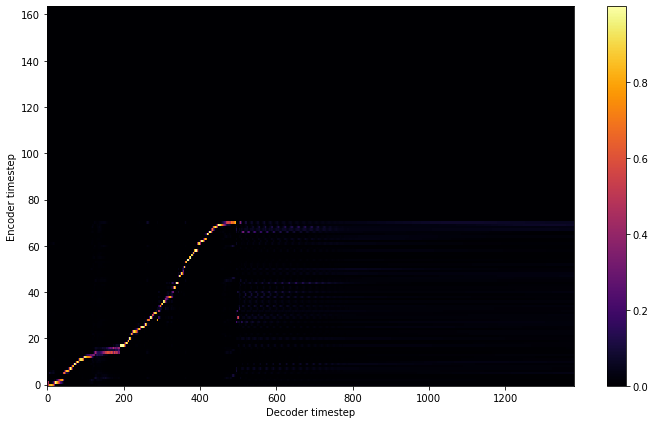

Saving model and optimizer state at iteration 22193 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 357 Iteration: 22193


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 357 Validation loss 22255:  0.114051  Time: 4.2m LR: 0.000202


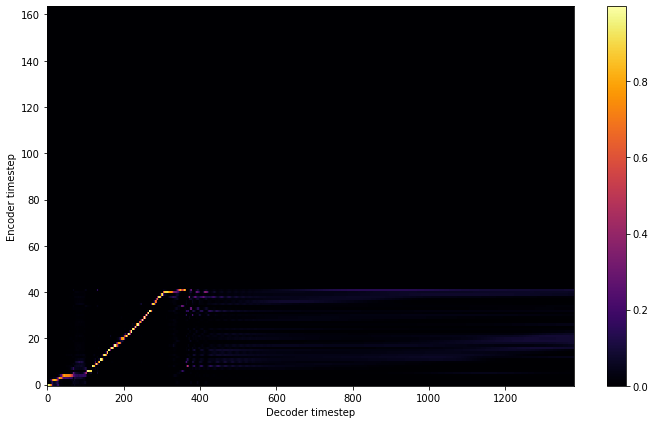

Saving model and optimizer state at iteration 22255 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 358 Iteration: 22255


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 358 Validation loss 22317:  0.113213  Time: 4.2m LR: 0.000200


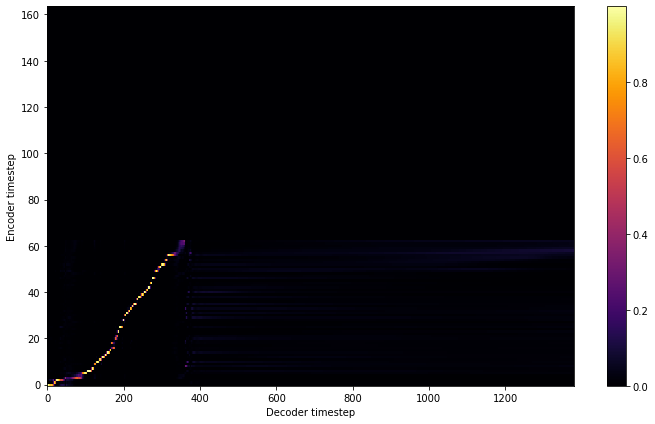

Saving model and optimizer state at iteration 22317 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 359 Iteration: 22317


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 359 Validation loss 22379:  0.112444  Time: 4.1m LR: 0.000199


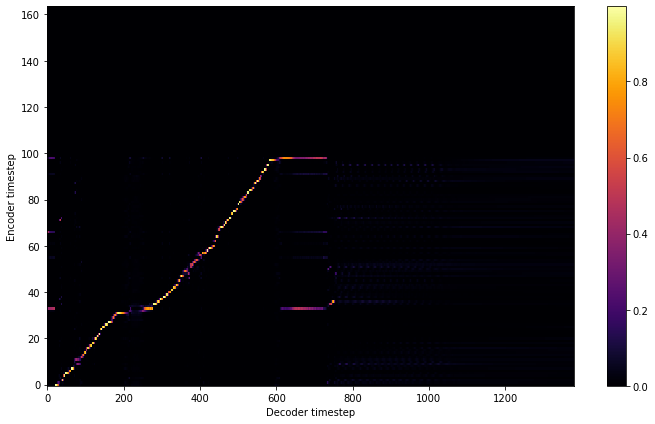

Saving model and optimizer state at iteration 22379 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 360 Iteration: 22379


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 360 Validation loss 22441:  0.112965  Time: 4.2m LR: 0.000197


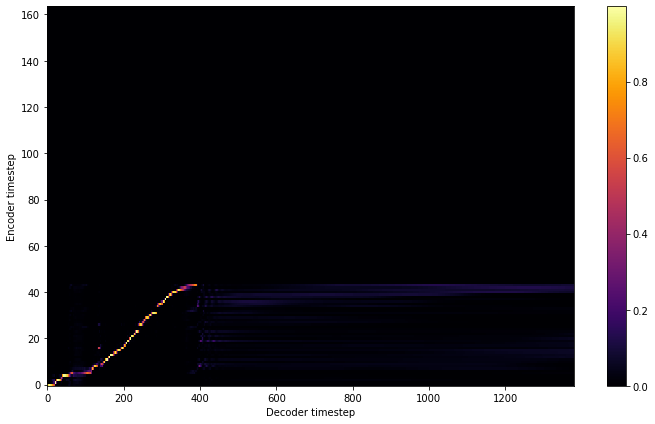

Saving model and optimizer state at iteration 22441 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 361 Iteration: 22441


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 361 Validation loss 22503:  0.113109  Time: 4.2m LR: 0.000196


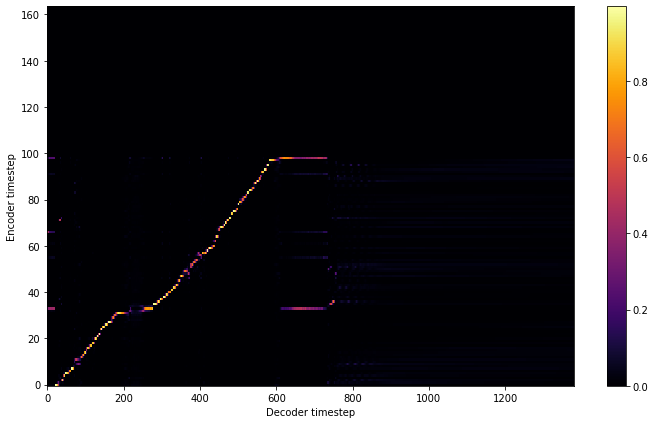

Saving model and optimizer state at iteration 22503 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 362 Iteration: 22503


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 362 Validation loss 22565:  0.113645  Time: 4.1m LR: 0.000194


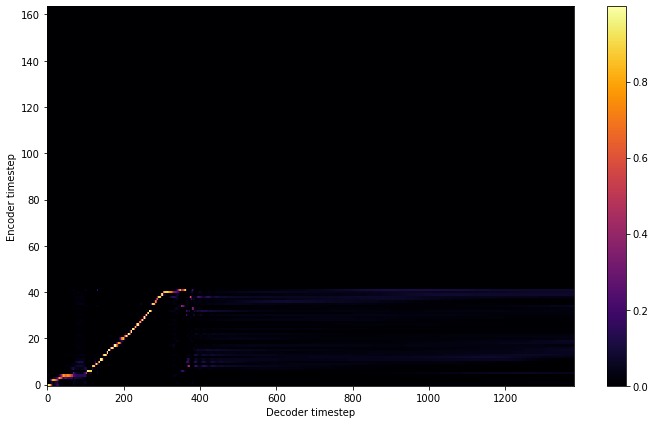

Saving model and optimizer state at iteration 22565 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 363 Iteration: 22565


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 363 Validation loss 22627:  0.112614  Time: 4.1m LR: 0.000193


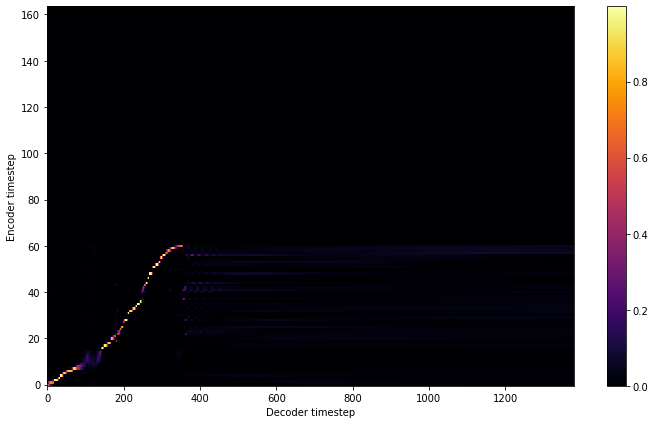

Saving model and optimizer state at iteration 22627 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 364 Iteration: 22627


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 364 Validation loss 22689:  0.112349  Time: 4.2m LR: 0.000191


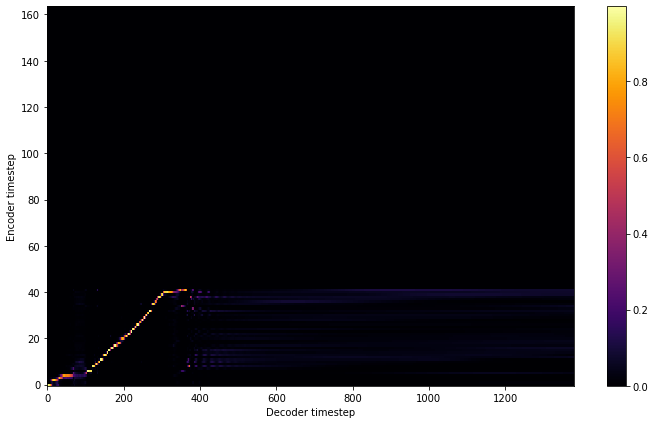

Saving model and optimizer state at iteration 22689 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 365 Iteration: 22689


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 365 Validation loss 22751:  0.113466  Time: 4.2m LR: 0.000190


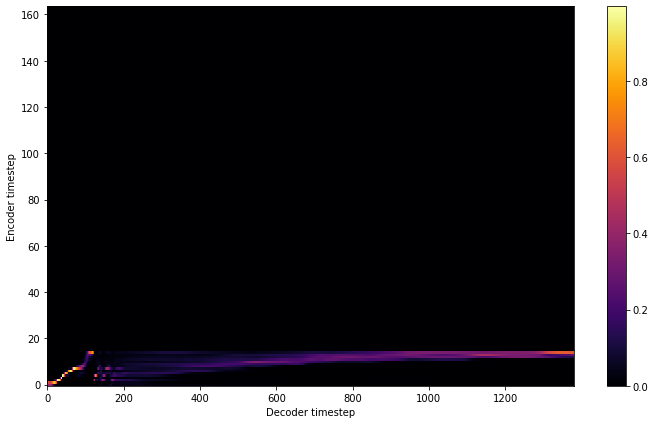

Saving model and optimizer state at iteration 22751 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 366 Iteration: 22751


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 366 Validation loss 22813:  0.113297  Time: 4.1m LR: 0.000188


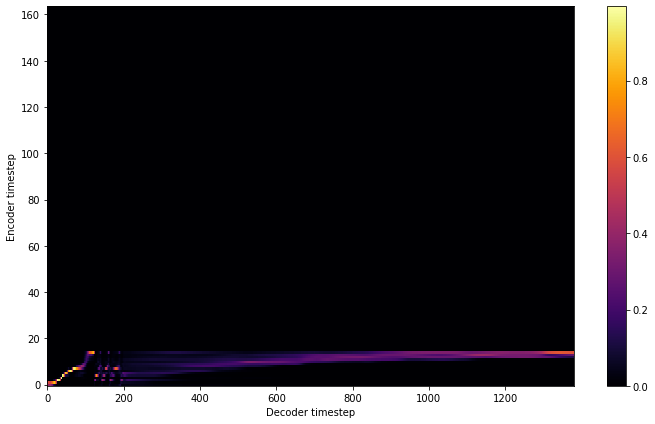

Saving model and optimizer state at iteration 22813 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 367 Iteration: 22813


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 367 Validation loss 22875:  0.113324  Time: 4.2m LR: 0.000187


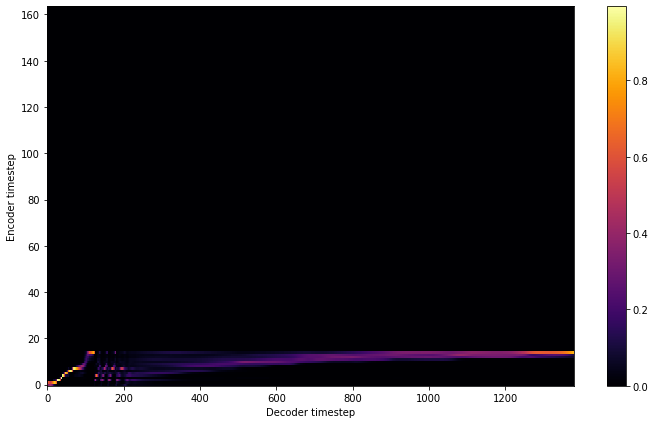

Saving model and optimizer state at iteration 22875 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 368 Iteration: 22875


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 368 Validation loss 22937:  0.112813  Time: 4.2m LR: 0.000185


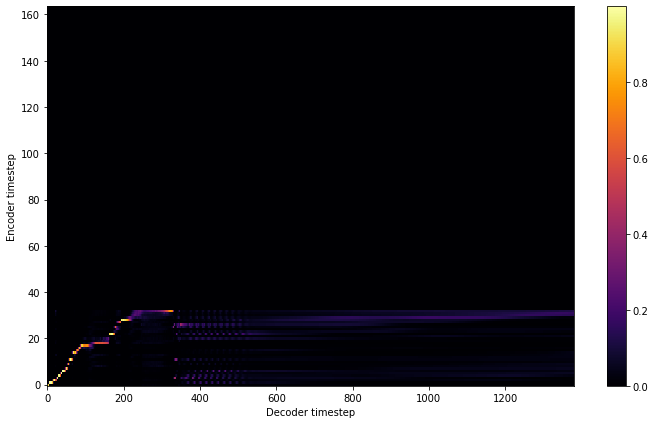

Saving model and optimizer state at iteration 22937 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 369 Iteration: 22937


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 369 Validation loss 22999:  0.111928  Time: 4.2m LR: 0.000184


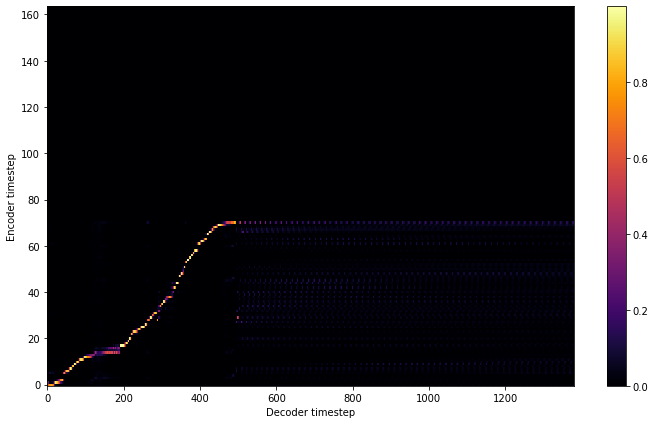

Saving model and optimizer state at iteration 22999 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 370 Iteration: 22999


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 370 Validation loss 23061:  0.111978  Time: 4.2m LR: 0.000183


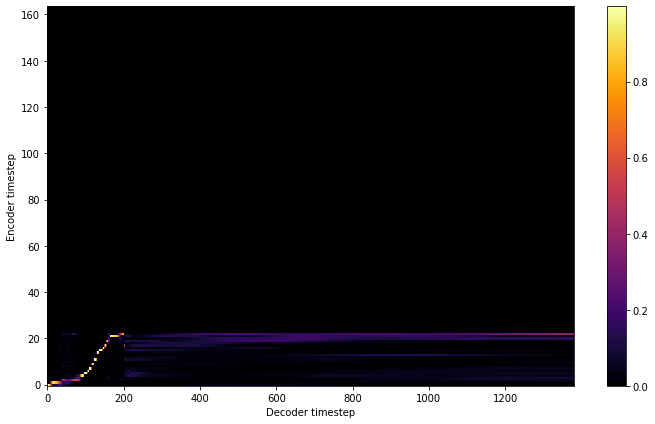

Saving model and optimizer state at iteration 23061 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 371 Iteration: 23061


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 371 Validation loss 23123:  0.112506  Time: 4.2m LR: 0.000181


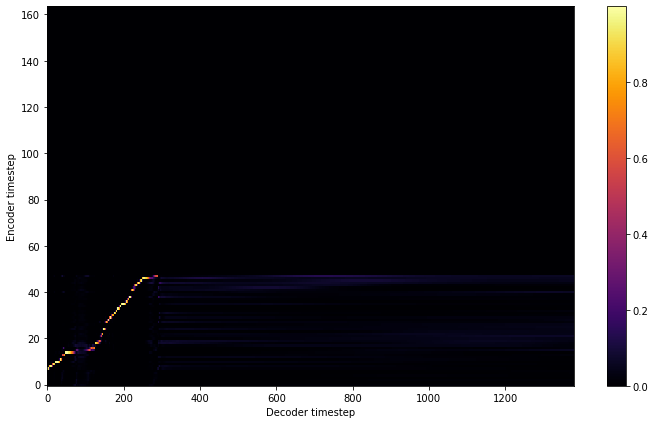

Saving model and optimizer state at iteration 23123 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 372 Iteration: 23123


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 372 Validation loss 23185:  0.112732  Time: 4.1m LR: 0.000180


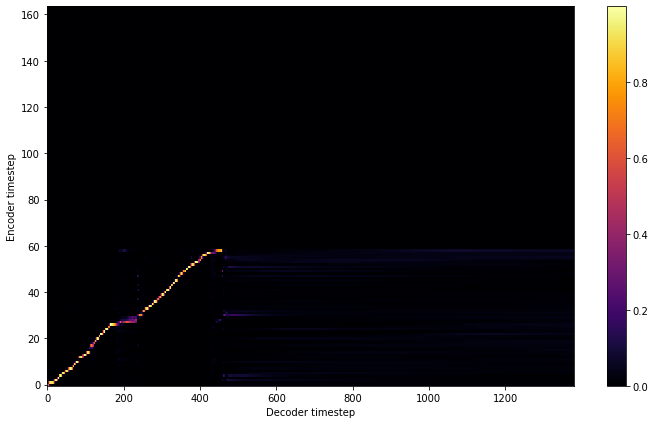

Saving model and optimizer state at iteration 23185 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 373 Iteration: 23185


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 373 Validation loss 23247:  0.112363  Time: 4.1m LR: 0.000178


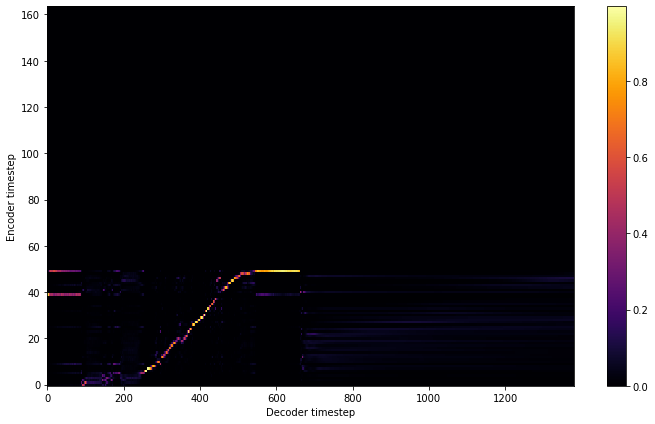

Saving model and optimizer state at iteration 23247 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 374 Iteration: 23247


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 374 Validation loss 23309:  0.116152  Time: 4.1m LR: 0.000177


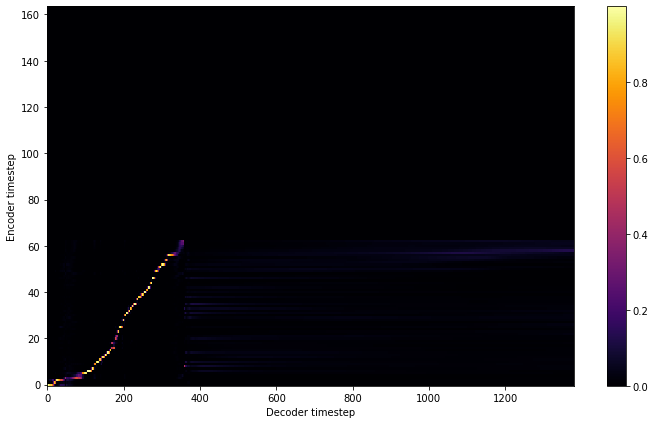

Saving model and optimizer state at iteration 23309 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 375 Iteration: 23309


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 375 Validation loss 23371:  0.113466  Time: 4.2m LR: 0.000176


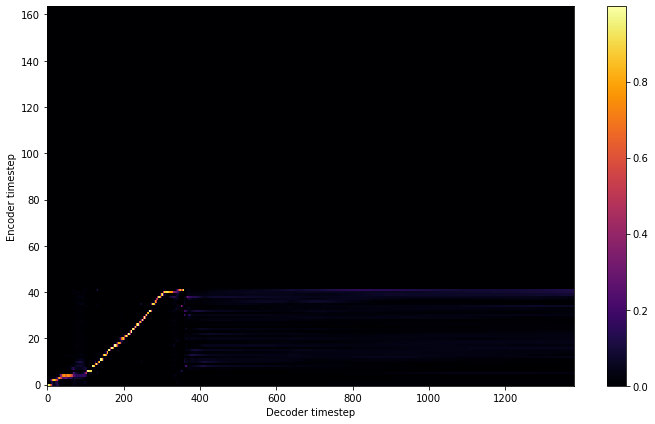

Saving model and optimizer state at iteration 23371 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 376 Iteration: 23371


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 376 Validation loss 23433:  0.112579  Time: 4.2m LR: 0.000174


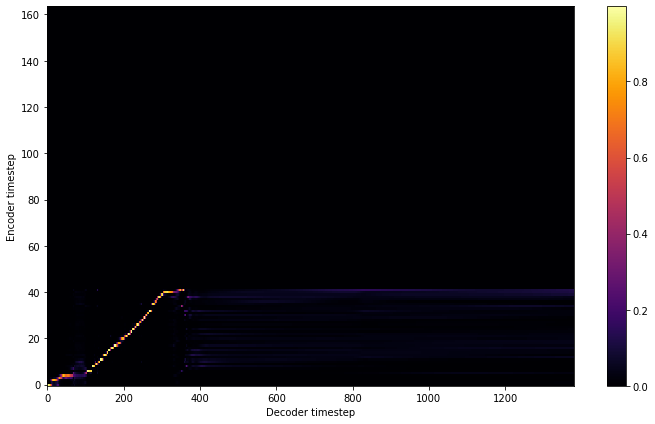

Saving model and optimizer state at iteration 23433 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 377 Iteration: 23433


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 377 Validation loss 23495:  0.112416  Time: 4.1m LR: 0.000173


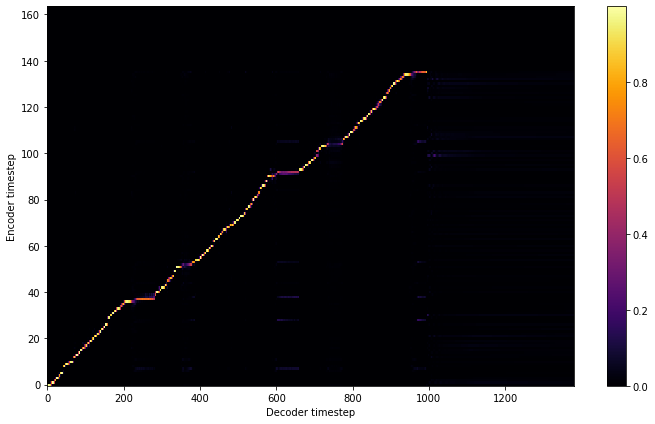

Saving model and optimizer state at iteration 23495 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 378 Iteration: 23495


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 378 Validation loss 23557:  0.111943  Time: 4.1m LR: 0.000172


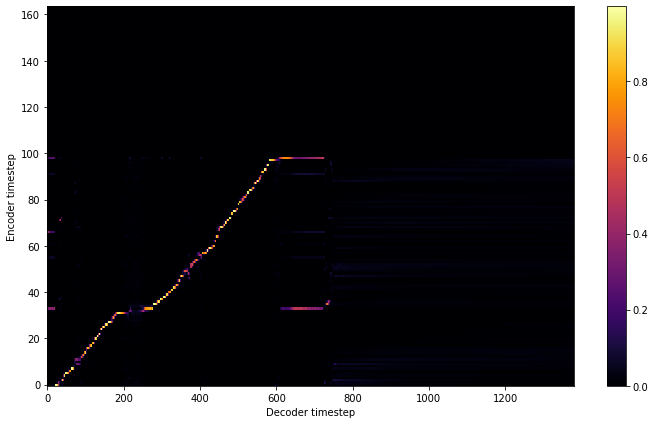

Saving model and optimizer state at iteration 23557 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 379 Iteration: 23557


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 379 Validation loss 23619:  0.114819  Time: 4.2m LR: 0.000170


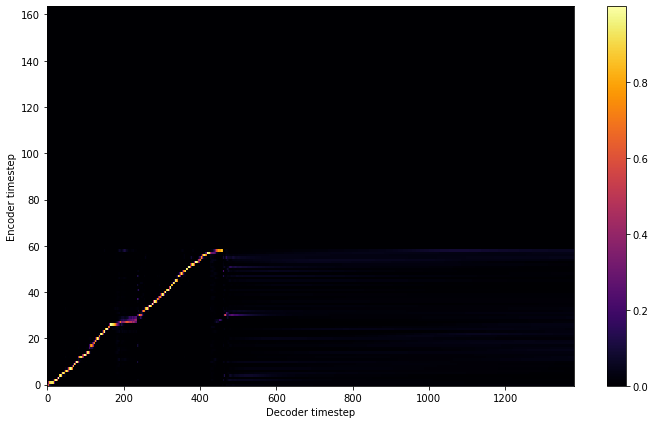

Saving model and optimizer state at iteration 23619 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 380 Iteration: 23619


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 380 Validation loss 23681:  0.111154  Time: 4.1m LR: 0.000169


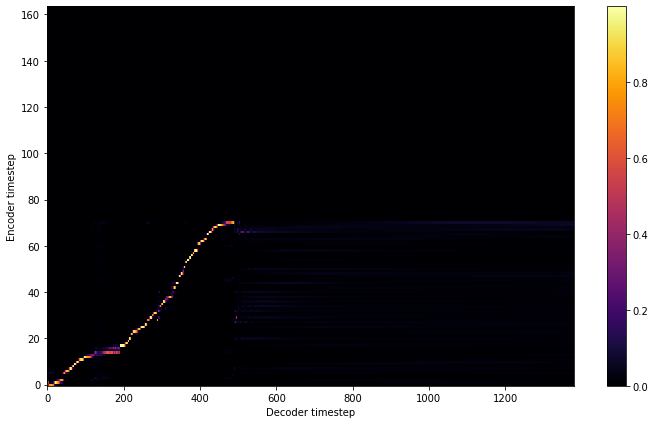

Saving model and optimizer state at iteration 23681 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 381 Iteration: 23681


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 381 Validation loss 23743:  0.111277  Time: 4.2m LR: 0.000168


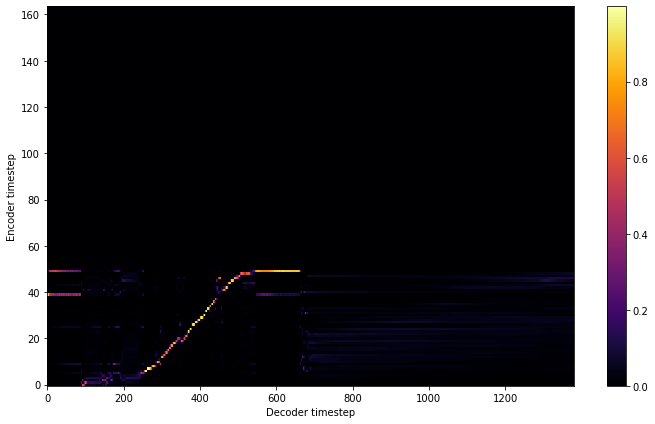

Saving model and optimizer state at iteration 23743 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 382 Iteration: 23743


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 382 Validation loss 23805:  0.111404  Time: 4.2m LR: 0.000166


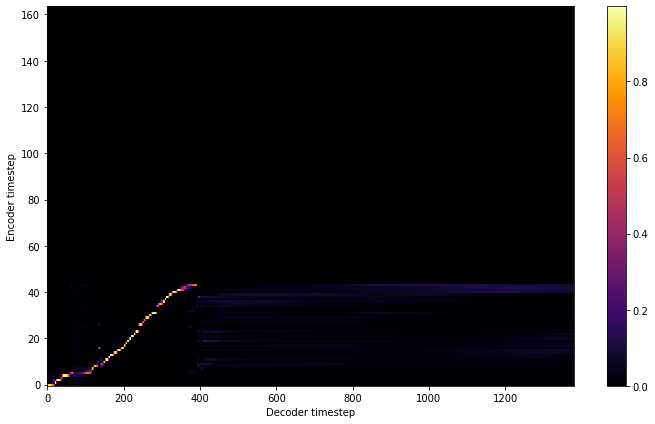

Saving model and optimizer state at iteration 23805 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 383 Iteration: 23805


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 383 Validation loss 23867:  0.110851  Time: 4.2m LR: 0.000165


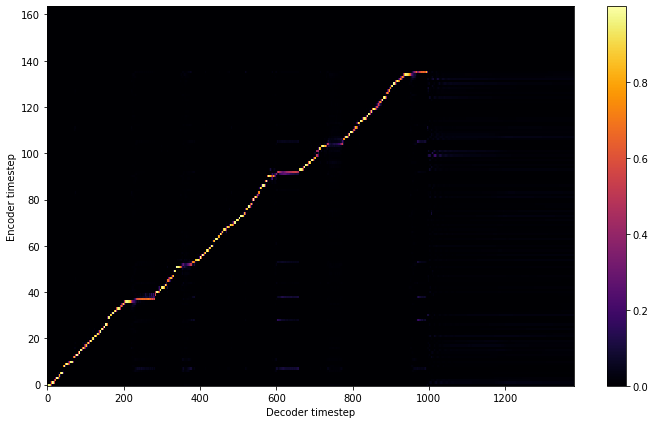

Saving model and optimizer state at iteration 23867 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 384 Iteration: 23867


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 384 Validation loss 23929:  0.110669  Time: 4.2m LR: 0.000164


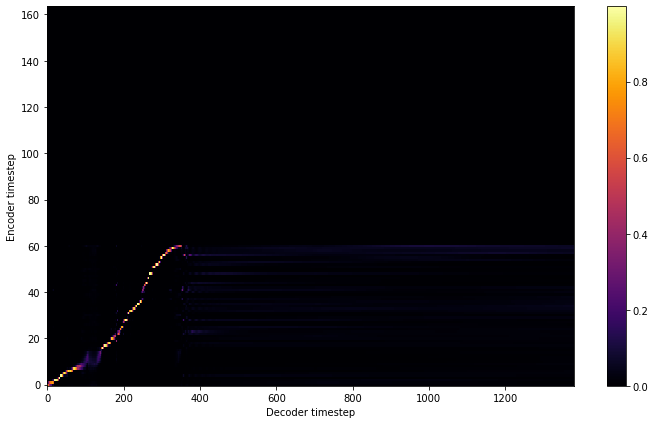

Saving model and optimizer state at iteration 23929 to /content/drive/MyDrive/colab/outdir/kurumi
Model Saved

Starting Epoch: 385 Iteration: 23929


  0%|          | 0/62 [00:00<?, ?it/s]

In [ ]:
#@title 开始训练
#@markdown  Validation loss 越小，拟合效果可能越好
if os.getcwd() != '/content/tacotron2':
    os.chdir('/content/tacotron2')
print('FP16 Run:', hparams.fp16_run)
print('Dynamic Loss Scaling:', hparams.dynamic_loss_scaling)
print('Distributed Run:', hparams.distributed_run)
print('cuDNN Enabled:', hparams.cudnn_enabled)
print('cuDNN Benchmark:', hparams.cudnn_benchmark)
train(output_directory, log_directory, checkpoint_path,
      warm_start, n_gpus, rank, group_name, hparams, log_directory2)

#语音合成

##用HiFi-GAN转换##

In [ ]:
#@title 安装依赖
!pip install -U tensorflow==1.15.2
!pip install -q unidecode tensorboardX
!pip install librosa==0.8.0
!pip install pysoundfile==0.9.0.post1
!pip install unidecode==1.3.4
!pip install pyopenjtalk==0.2.0
!pip install inflect==5.6.2
!pip install janome==0.4.2
!pip install tqdm -q
!pip install gdown
!pip install -q librosa unidecode

In [ ]:
#@markdown 配置：

#@markdown 重新运行即可应用配置的更改

#国际 HiFi-GAN 模型(有点机器音): 1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW
#@markdown 你训练好的tacotron2模型的路径填在`Tacotron2_Model`这里
Tacotron2_Model = '/content/drive/MyDrive/colab/outdir/kurumi'#@param {type:"string"}
TACOTRON2_ID = Tacotron2_Model
HIFIGAN_ID = "1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW"
#@markdown 选择预处理文本的cleaner
text_cleaner = 'japanese_phrase_cleaners'#@param {type:"string"}

# Check if Initilized
try:
    initilized
except NameError:
    print("Setting up, please wait.\n")

    from tqdm.notebook import tqdm
    with tqdm(total=5, leave=False) as pbar:
        import os
        from os.path import exists, join, basename, splitext
        git_repo_url = 'https://github.com/CjangCjengh/tacotron2-japanese.git'
        project_name = splitext(basename(git_repo_url))[0]
        if not exists(project_name):
            # clone and install
            !git clone -q --recursive {git_repo_url}
            !git clone -q --recursive https://github.com/SortAnon/hifi-gan
            
        pbar.update(1) # downloaded TT2 and HiFi-GAN
        import sys
        sys.path.append('hifi-gan')
        sys.path.append(project_name)
        import time
        import matplotlib
        import matplotlib.pylab as plt
        import gdown
        d = 'https://drive.google.com/uc?id='

        %matplotlib inline
        import IPython.display as ipd
        import numpy as np
        import torch
        import json
        from hparams import create_hparams
        from model import Tacotron2
        from layers import TacotronSTFT
        from audio_processing import griffin_lim
        from text import text_to_sequence
        from env import AttrDict
        from meldataset import MAX_WAV_VALUE
        from models import Generator

        pbar.update(1) # initialized Dependancies

        graph_width = 900
        graph_height = 360
        def plot_data(data, figsize=(int(graph_width/100), int(graph_height/100))):
            %matplotlib inline
            fig, axes = plt.subplots(1, len(data), figsize=figsize)
            for i in range(len(data)):
                axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                            interpolation='none', cmap='inferno')
            fig.canvas.draw()
            plt.show()

        # Setup Pronounciation Dictionary
        !gdown --id '1E12g_sREdcH5vuZb44EZYX8JjGWQ9rRp'
        thisdict = {}
        for line in reversed((open('merged.dict.txt', "r").read()).splitlines()):
            thisdict[(line.split(" ",1))[0]] = (line.split(" ",1))[1].strip()

        pbar.update(1) # Downloaded and Set up Pronounciation Dictionary

        def ARPA(text, punctuation=r"!?,.;", EOS_Token=True):
            out = ''
            for word_ in text.split(" "):
                word=word_; end_chars = ''
                while any(elem in word for elem in punctuation) and len(word) > 1:
                    if word[-1] in punctuation: end_chars = word[-1] + end_chars; word = word[:-1]
                    else: break
                try:
                    word_arpa = thisdict[word.upper()]
                    word = "{" + str(word_arpa) + "}"
                except KeyError: pass
                out = (out + " " + word + end_chars).strip()
            if EOS_Token and out[-1] != ";": out += ";"
            return out

        def get_hifigan(MODEL_ID):
            # Download HiFi-GAN
            hifigan_pretrained_model = 'hifimodel'
            gdown.download(d+MODEL_ID, hifigan_pretrained_model, quiet=False)
            if not exists(hifigan_pretrained_model):
                raise Exception("HiFI-GAN model failed to download!")

            # Load HiFi-GAN
            conf = os.path.join("hifi-gan", "config_v1.json")
            with open(conf) as f:
                json_config = json.loads(f.read())
            h = AttrDict(json_config)
            torch.manual_seed(h.seed)
            hifigan = Generator(h).to(torch.device("cuda"))
            state_dict_g = torch.load(hifigan_pretrained_model, map_location=torch.device("cuda"))
            hifigan.load_state_dict(state_dict_g["generator"])
            hifigan.eval()
            hifigan.remove_weight_norm()
            return hifigan, h

        hifigan, h = get_hifigan(HIFIGAN_ID)
        pbar.update(1) # Downloaded and Set up HiFi-GAN

        def has_MMI(STATE_DICT):
            return any(True for x in STATE_DICT.keys() if "mi." in x)

        def get_Tactron2(MODEL_ID):
            # Download Tacotron2
            tacotron2_pretrained_model = TACOTRON2_ID
            if not exists(tacotron2_pretrained_model):
                raise Exception("Tacotron2 model failed to download!")
            # Load Tacotron2 and Config
            hparams = create_hparams()
            hparams.sampling_rate = 22050
            hparams.max_decoder_steps = 3000 # Max Duration
            hparams.gate_threshold = 0.25 # Model must be 25% sure the clip is over before ending generation
            model = Tacotron2(hparams)
            state_dict = torch.load(tacotron2_pretrained_model)['state_dict']
            if has_MMI(state_dict):
                raise Exception("ERROR: This notebook does not currently support MMI models.")
            model.load_state_dict(state_dict)
            _ = model.cuda().eval().half()
            return model, hparams

        model, hparams = get_Tactron2(TACOTRON2_ID)
        previous_tt2_id = TACOTRON2_ID

        pbar.update(1) # Downloaded and Set up Tacotron2

        # Extra Info
        def end_to_end_infer(text, pronounciation_dictionary, show_graphs):
            for i in [x for x in text.split("\n") if len(x)]:
                if not pronounciation_dictionary:
                    if i[-1] != ";": i=i+";" 
                else: i = ARPA(i)
                with torch.no_grad(): # save VRAM by not including gradients
                    sequence = np.array(text_to_sequence(i, [text_cleaner]))[None, :]
                    sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
                    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
                    if show_graphs:
                        plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
                                alignments.float().data.cpu().numpy()[0].T))
                    y_g_hat = hifigan(mel_outputs_postnet.float())
                    audio = y_g_hat.squeeze()
                    audio = audio * MAX_WAV_VALUE
                    print("")
                    ipd.display(ipd.Audio(audio.cpu().numpy().astype("int16"), rate=hparams.sampling_rate))
    from IPython.display import clear_output
    clear_output()
    initilized = "Ready"

if previous_tt2_id != TACOTRON2_ID:
    print("Updating Models")
    model, hparams = get_Tactron2(TACOTRON2_ID)
    hifigan, h = get_hifigan(HIFIGAN_ID)
    previous_tt2_id = TACOTRON2_ID

pronounciation_dictionary = False #@param {type:"boolean"}
# disables automatic ARPAbet conversion, useful for inputting your own ARPAbet pronounciations or just for testing
show_graphs = True #@param {type:"boolean"}
max_duration = 25 #this does nothing
model.decoder.max_decoder_steps = 1000 #@param {type:"integer"}
stop_threshold = 0.324 #@param {type:"number"}
model.decoder.gate_threshold = stop_threshold

#@markdown ---

print(f"Current Config:\npronounciation_dictionary: {pronounciation_dictionary}\nshow_graphs: {show_graphs}\nmax_duration (in seconds): {max_duration}\nstop_threshold: {stop_threshold}\n\n")

time.sleep(1)
print("输入要转换成语音的文本.")
contents = []
while True:
    try:
        print("-"*50)
        line = input()
        if line == "":
            continue
        end_to_end_infer(line, pronounciation_dictionary, show_graphs)
    except EOFError:
        break
    except KeyboardInterrupt:
        print("程序终止...")
        break

##用 Waveglow##
（个人不建议使用）

**使用LJ Speech数据集预先训练权重的WaveGlow模型可以从这个地址下载：https://catalog.ngc.nvidia.com/orgs/nvidia/models/waveglow_ljs_256channels**


In [ ]:
#@title 安装 Tacotron 和 Waveglow
!pip install -U tensorflow==1.15.2
import os
from os.path import exists, join, basename, splitext
!pip install gdown
git_repo_url = 'https://github.com/CjangCjengh/tacotron2-japanese.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install
  !git clone -q --recursive {git_repo_url}
  !cd {project_name}/waveglow && git checkout 2fd4e63
  !pip install -q librosa unidecode
  
import sys
sys.path.append(join(project_name, 'waveglow/'))
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
import gdown
d = 'https://drive.google.com/uc?id='

In [ ]:
#@title 加载预训练模型
force_download_TT2 = True
tacotron2_pretrained_model = '/PATH/Your Tactron2 Model'#@param {type:"string"}
waveglow_pretrained_model = '/PATH/waveglow_256channels_ljs_v3.pt'#@param {type:"string"}

In [ ]:
#@title 安装 Tacotron 和 Waveglow 
%matplotlib inline
import IPython.display as ipd
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from text import text_to_sequence
from denoiser import Denoiser

graph_width = 900
graph_height = 360
def plot_data(data, figsize=(int(graph_width/100), int(graph_height/100))):
    %matplotlib inline
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none', cmap='inferno')
    fig.canvas.draw()
    plt.show()

!gdown --id '1E12g_sREdcH5vuZb44EZYX8JjGWQ9rRp'
thisdict = {}
for line in reversed((open('merged.dict.txt', "r").read()).splitlines()):
    thisdict[(line.split(" ",1))[0]] = (line.split(" ",1))[1].strip()
def ARPA(text):
    out = ''
    for word_ in text.split(" "):
        word=word_; end_chars = ''
        while any(elem in word for elem in r"!?,.;") and len(word) > 1:
            if word[-1] == '!': end_chars = '!' + end_chars; word = word[:-1]
            if word[-1] == '?': end_chars = '?' + end_chars; word = word[:-1]
            if word[-1] == ',': end_chars = ',' + end_chars; word = word[:-1]
            if word[-1] == '.': end_chars = '.' + end_chars; word = word[:-1]
            if word[-1] == ';': end_chars = ';' + end_chars; word = word[:-1]
            else: break
        try: word_arpa = thisdict[word.upper()]
        except: word_arpa = ''
        if len(word_arpa)!=0: word = "{" + str(word_arpa) + "}"
        out = (out + " " + word + end_chars).strip()
    if out[-1] != ";": out = out + ";"
    return out

#torch.set_grad_enabled(False)

# initialize Tacotron2 with the pretrained model
hparams = create_hparams()

In [ ]:
#@title 参数
# Load Tacotron2 (run this cell every time you change the model)
hparams.sampling_rate = 22050 # Don't change this
hparams.max_decoder_steps = 1000 # How long the audio will be before it cuts off (1000 is about 11 seconds)
hparams.gate_threshold = 0.1 # Model must be 90% sure the clip is over before ending generation (the higher this number is, the more likely that the AI will keep generating until it reaches the Max Decoder Steps)
model = Tacotron2(hparams)
model.load_state_dict(torch.load(tacotron2_pretrained_model)['state_dict'])
_ = model.cuda().eval().half()

# Load WaveGlow
waveglow = torch.load(waveglow_pretrained_model)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

In [ ]:
#@title 开始合成！
text = 'Your Text Here'#@param {type:"string"}
sigma = 0.8
denoise_strength = 0.324
raw_input = True # disables automatic ARPAbet conversion, useful for inputting your own ARPAbet pronounciations or just for testing.
                  # should be True if synthesizing a non-English language

for i in text.split("\n"):
    if len(i) < 1: continue;
    print(i)
    if raw_input:
        if i[-1] != ";": i=i+";" 
    else: i = ARPA(i)
    print(i)
    with torch.no_grad(): # save VRAM by not including gradients
        sequence = np.array(text_to_sequence(i, ['english_cleaners']))[None, :]
        sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
        mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
        plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
                alignments.float().data.cpu().numpy()[0].T))
        audio = waveglow.infer(mel_outputs_postnet, sigma=sigma); print(""); ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))